#  Anomaly Detection in Pump

In this project, Isolation Forest and KMeans approach have been adopted for predicting the status of the pump. 

There are 3 types of data:

1. Timestamp data
2. Sensor data(52 series): All values are raw values
3. Machine status: This is target label that I want to predict when the failure will happen

### Loading required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', font_scale=1.5)
%matplotlib inline
plt.rcParams['figure.figsize']=[12,8]

### Get the data

In [2]:
data=pd.read_csv('sensor.csv')

### Explore the data

In this section, the characterstics of each attribute will be studied which includes:

1. Name and type of the data(categorical, int/float), missing values)
2. Visualize the data.
3. Study the correlations between the observation.

In [3]:
data.shape[0], data.shape[1]

(220320, 55)

The dataset contains 220320 rows and 55 columns.

In [4]:
data.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

As shown above the dataset consists mainly of numerical sensor readings, complemented by categorical machine status and temporal timestamp information. 
Addressing missing values and further exploring the relationships within the data will be key steps in gaining deeper insights and building effective models.

In [6]:
data["machine_status"].value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

The 'machine_status' attribute, representing the machine's operational state, exhibits a significant data imbalance with a majority of instances labeled as 'NORMAL' and relatively fewer instances for 'RECOVERING' and 'BROKEN' states.

In [7]:
data['Unnamed: 0'].value_counts()

Unnamed: 0
0         1
146871    1
146873    1
146874    1
146875    1
         ..
73443     1
73444     1
73445     1
73446     1
220319    1
Name: count, Length: 220320, dtype: int64

The Unnamed: 0 data hasn't any significance  in anaysising the anomaly detection as it only describes the serial number.

In [8]:
data.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


#### Checking Missing values

In [9]:
data.isnull().values.any(), data.columns[data.isnull().any()].tolist()

(True,
 ['sensor_00',
  'sensor_01',
  'sensor_02',
  'sensor_03',
  'sensor_04',
  'sensor_05',
  'sensor_06',
  'sensor_07',
  'sensor_08',
  'sensor_09',
  'sensor_10',
  'sensor_11',
  'sensor_12',
  'sensor_13',
  'sensor_14',
  'sensor_15',
  'sensor_16',
  'sensor_17',
  'sensor_18',
  'sensor_19',
  'sensor_20',
  'sensor_21',
  'sensor_22',
  'sensor_23',
  'sensor_24',
  'sensor_25',
  'sensor_26',
  'sensor_27',
  'sensor_28',
  'sensor_29',
  'sensor_30',
  'sensor_31',
  'sensor_32',
  'sensor_33',
  'sensor_34',
  'sensor_35',
  'sensor_36',
  'sensor_37',
  'sensor_38',
  'sensor_39',
  'sensor_40',
  'sensor_41',
  'sensor_42',
  'sensor_43',
  'sensor_44',
  'sensor_45',
  'sensor_46',
  'sensor_47',
  'sensor_48',
  'sensor_49',
  'sensor_50',
  'sensor_51'])

In [10]:
data.isnull().sum()

Unnamed: 0             0
timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16


In the dataset, with the exception of 'machine_status,' 'timestamp,' and unnamed columns, several attributes, including 'sensor_15,' 'sensor_51,' and 'sensor_00,' exhibit missing values, with counts of 220,320, 15,383, and 10,208, respectively.

#### Clean the Data

In [11]:
data.drop("sensor_15", axis=1, inplace=True)

In [12]:
data.columns

Index(['Unnamed: 0', 'timestamp', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12',
       'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [13]:
(data.isnull().sum().sort_values(ascending=False)/len(data))*100

sensor_50         34.956881
sensor_51          6.982117
sensor_00          4.633261
sensor_07          2.474129
sensor_08          2.317992
sensor_06          2.177741
sensor_09          2.085603
sensor_01          0.167484
sensor_30          0.118464
sensor_29          0.032680
sensor_32          0.030864
sensor_18          0.020879
sensor_17          0.020879
sensor_22          0.018609
sensor_25          0.016340
sensor_16          0.014070
sensor_38          0.012255
sensor_39          0.012255
sensor_40          0.012255
sensor_49          0.012255
sensor_41          0.012255
sensor_43          0.012255
sensor_44          0.012255
sensor_45          0.012255
sensor_46          0.012255
sensor_47          0.012255
sensor_48          0.012255
sensor_42          0.012255
sensor_14          0.009532
sensor_26          0.009078
sensor_02          0.008624
sensor_03          0.008624
sensor_04          0.008624
sensor_05          0.008624
sensor_10          0.008624
sensor_11          0

The calculated percentage of missing values reveals that, apart from 'sensor_15' and 'sensor_50,' all other sensor datasets significantly contribute to predicting the machine's status.

In [14]:
columns_to_fill = data.columns.difference(['Unnamed: 0', 'timestamp', 'machine_status', 'sensor_15'])

for column in columns_to_fill:
    median = data[column].median()
    data[column].fillna(median, inplace=True)

In [15]:
data.isnull().values.any()

False

In [16]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 53 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       220320 non-null  float64
 2   sensor_01       220320 non-null  float64
 3   sensor_02       220320 non-null  float64
 4   sensor_03       220320 non-null  float64
 5   sensor_04       220320 non-null  float64
 6   sensor_05       220320 non-null  float64
 7   sensor_06       220320 non-null  float64
 8   sensor_07       220320 non-null  float64
 9   sensor_08       220320 non-null  float64
 10  sensor_09       220320 non-null  float64
 11  sensor_10       220320 non-null  float64
 12  sensor_11       220320 non-null  float64
 13  sensor_12       220320 non-null  float64
 14  sensor_13       220320 non-null  float64
 15  sensor_14       220320 non-null  float64
 16  sensor_16       220320 non-null  float64
 17  sensor_17 

In [18]:
# convert timestamp into index
data['index']=pd.to_datetime(data['timestamp'])
data.index=data['index']

# drop the index and timestamp columns

data.drop(['index', 'timestamp'], inplace=True, axis=1)

### Exploratory Data Analysis

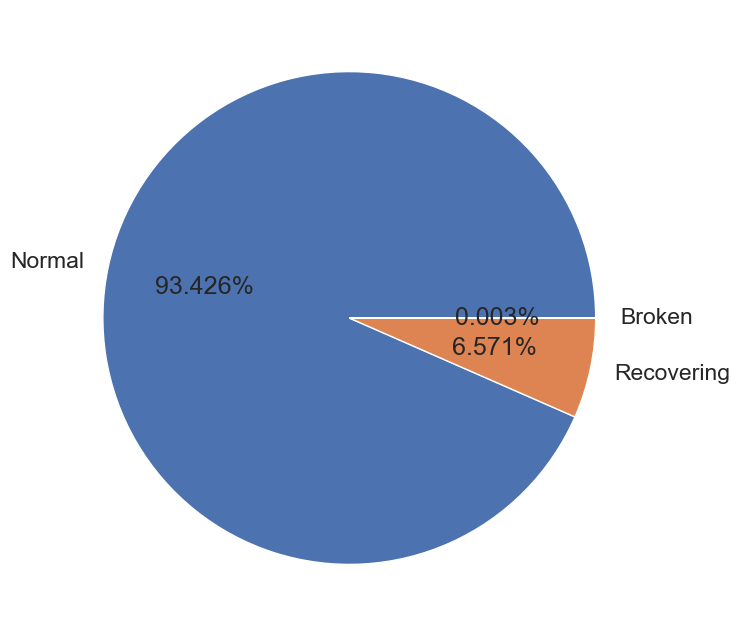

In [19]:
stroke_labels = ["Normal", "Recovering", "Broken"]
sizes = data.machine_status.value_counts()

plt.pie(x=sizes, autopct='%1.3f%%', labels=stroke_labels) #autopct='%1.3f%%' shows the amount of decimal point in the percentage
plt.show()


The target feature is highly imbalanced dataset.

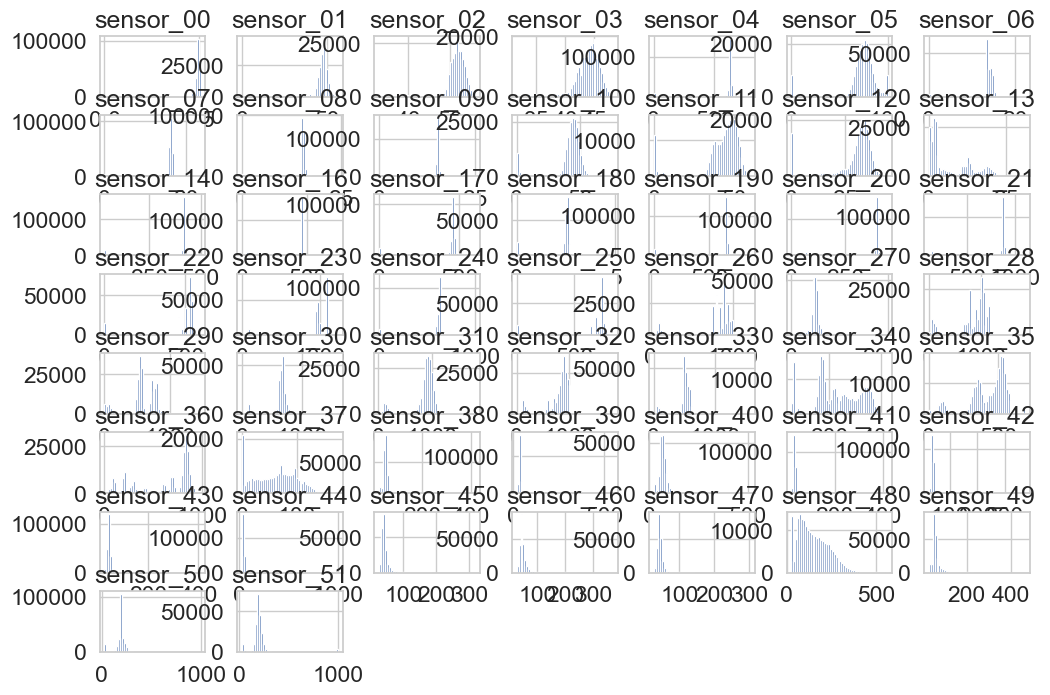

In [20]:
data.hist(bins=50, figsize=(12, 8))
plt.show()

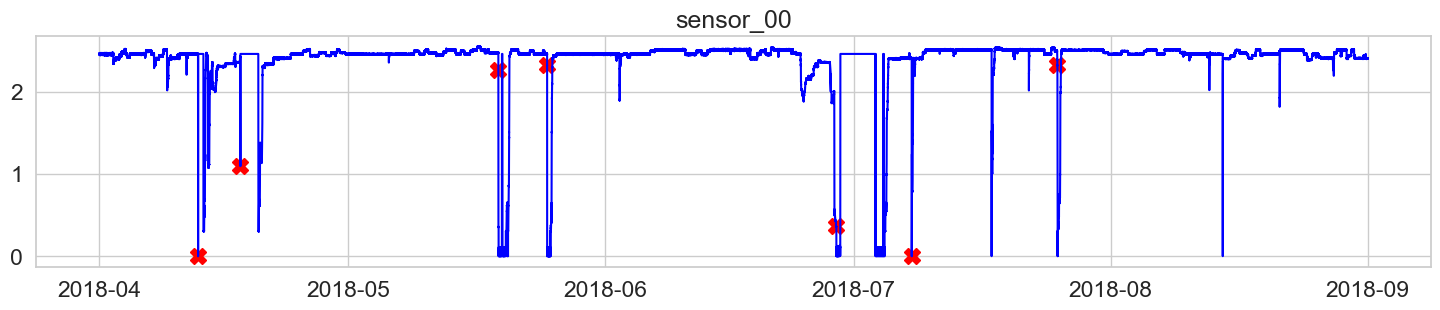

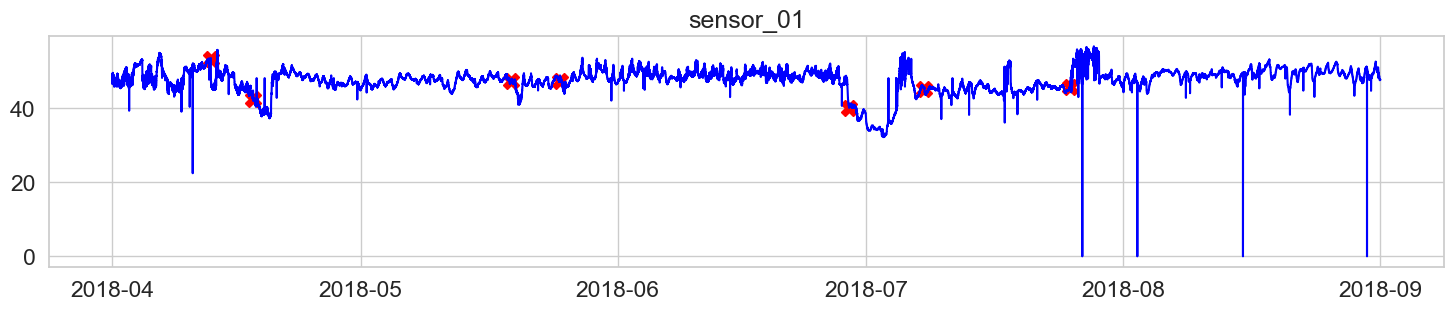

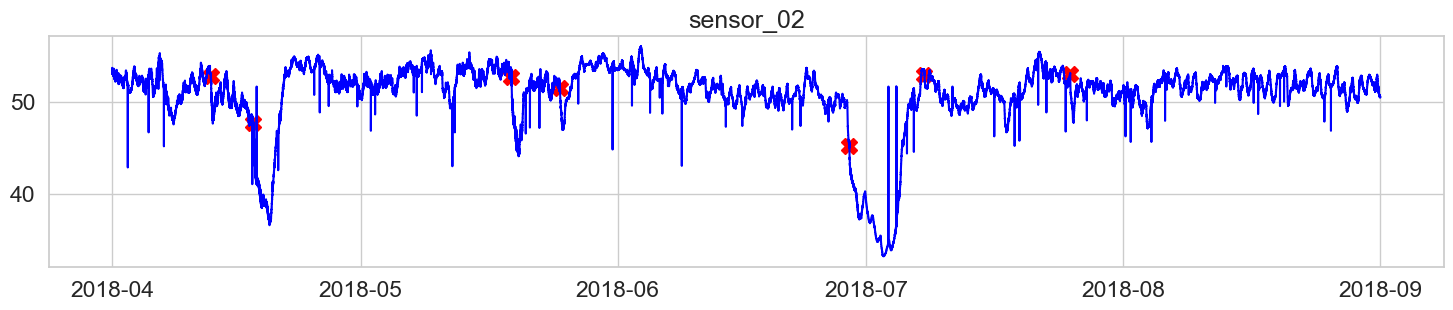

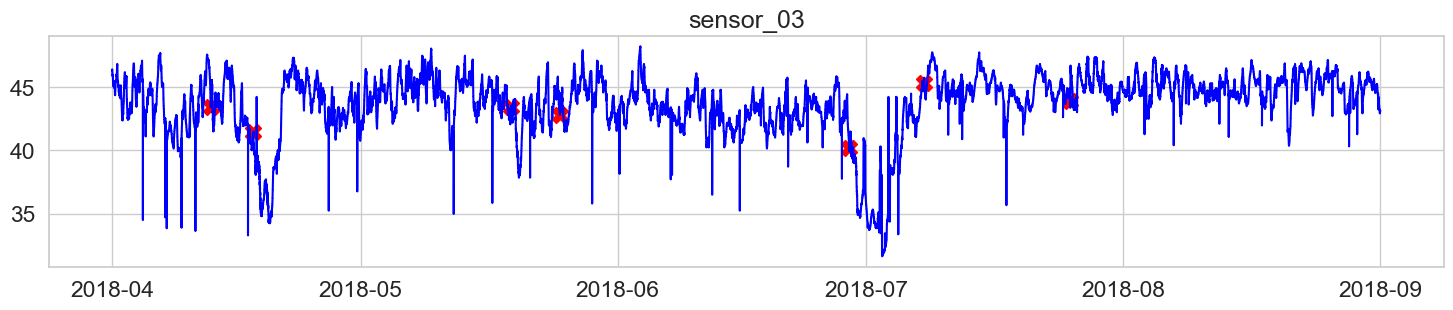

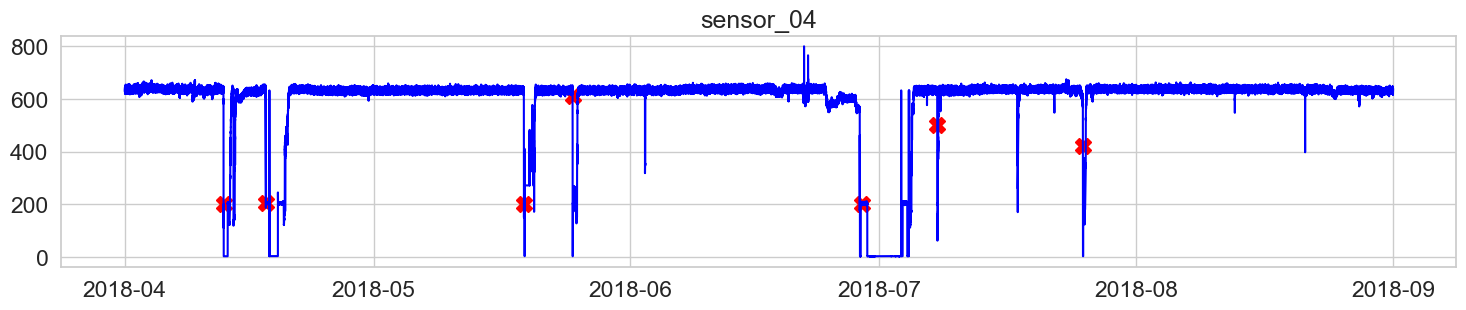

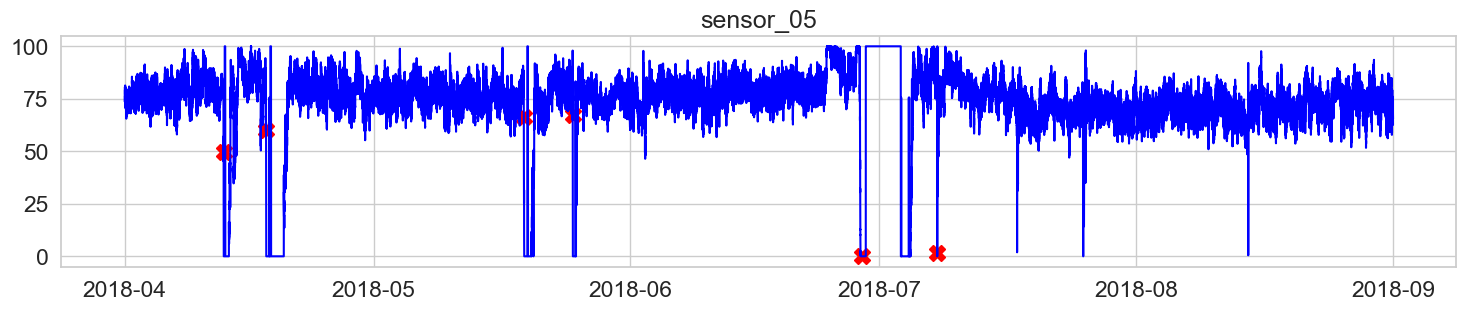

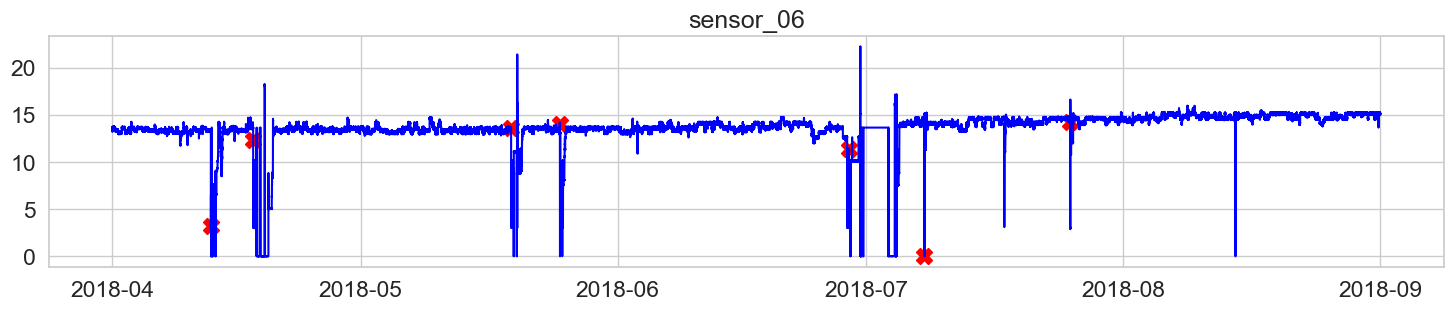

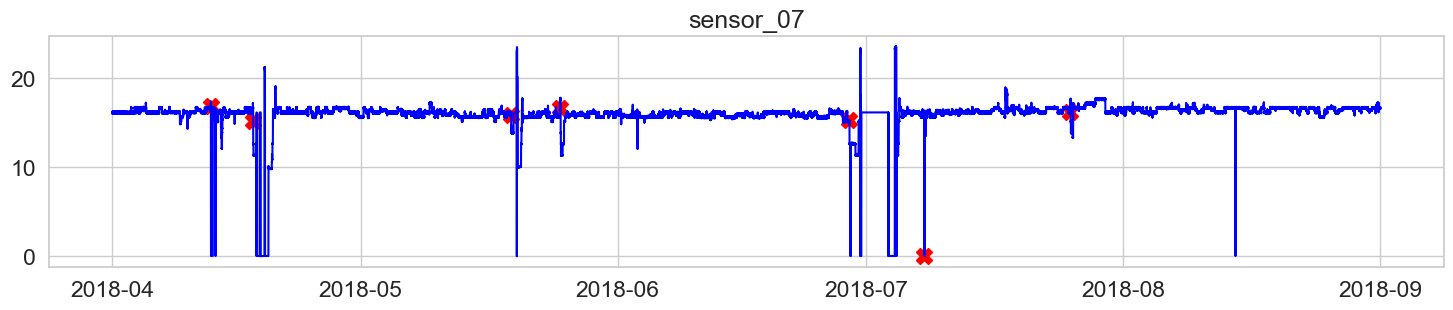

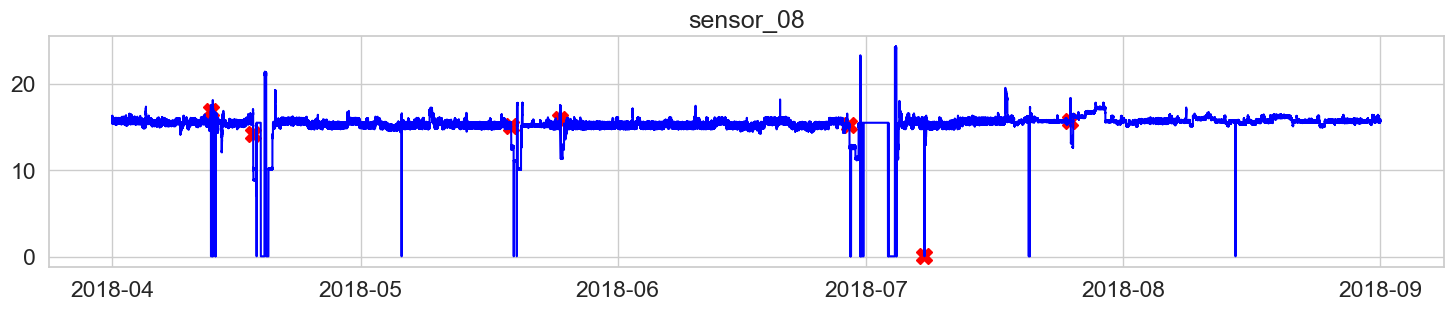

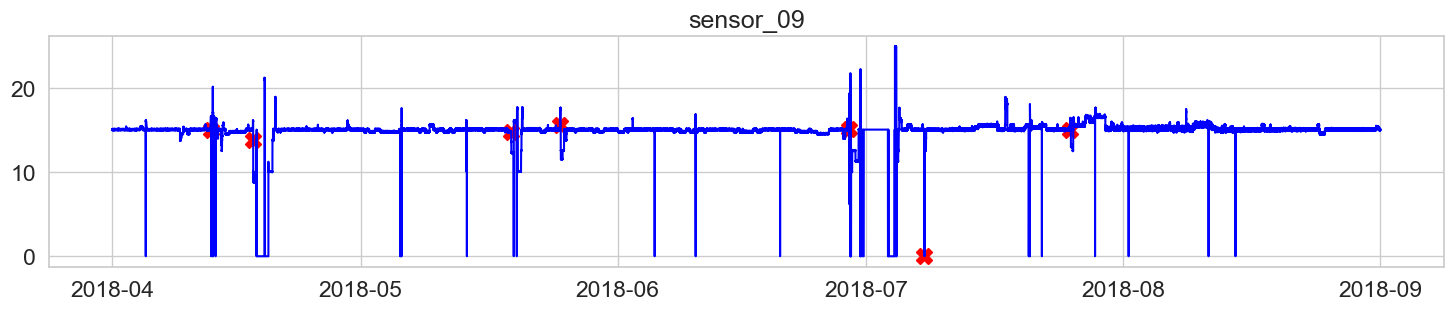

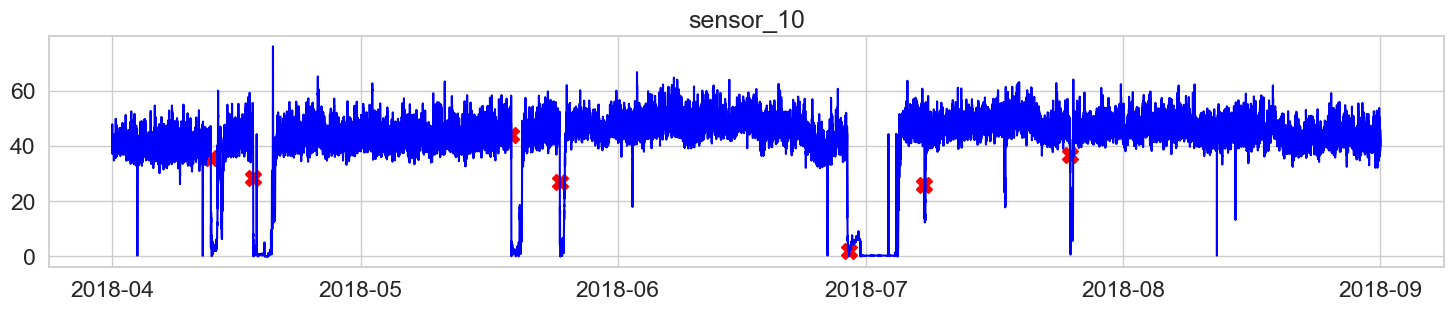

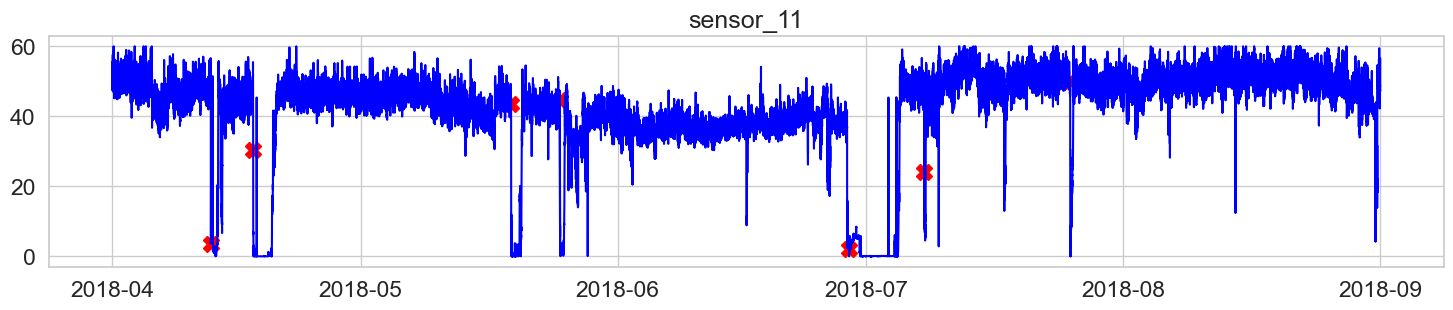

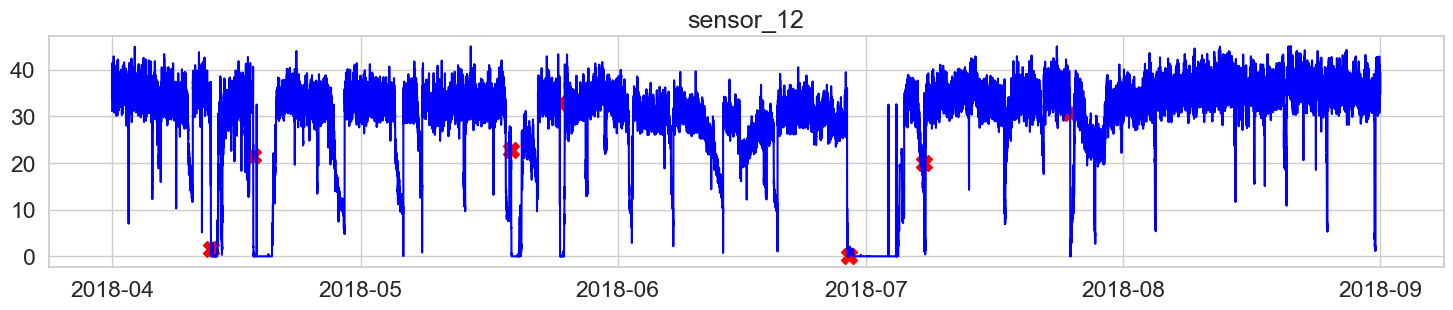

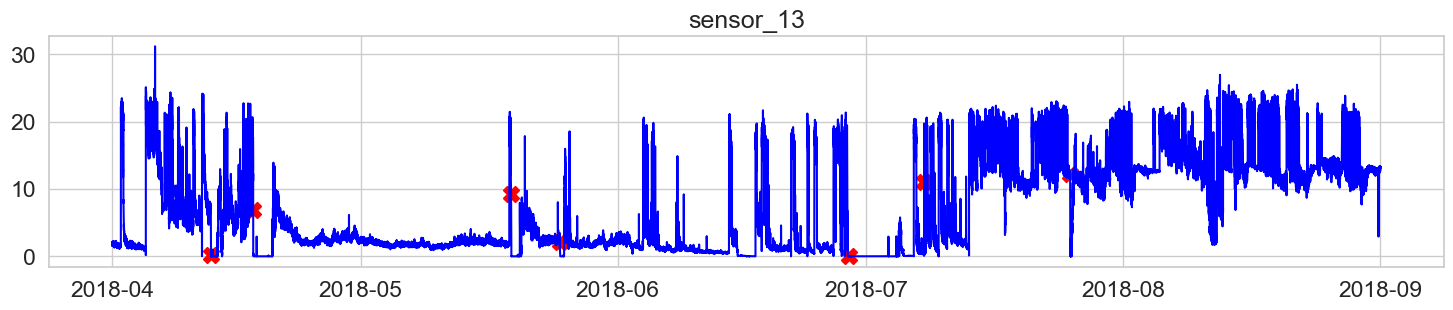

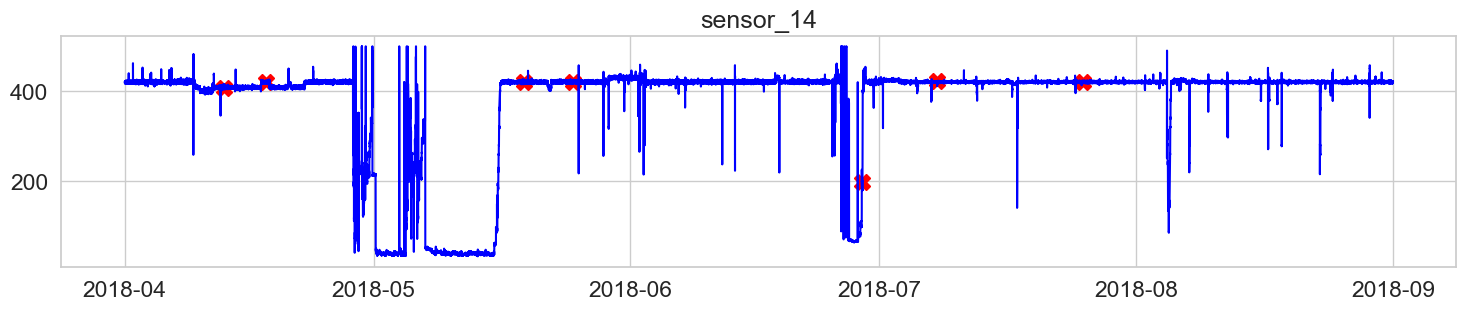

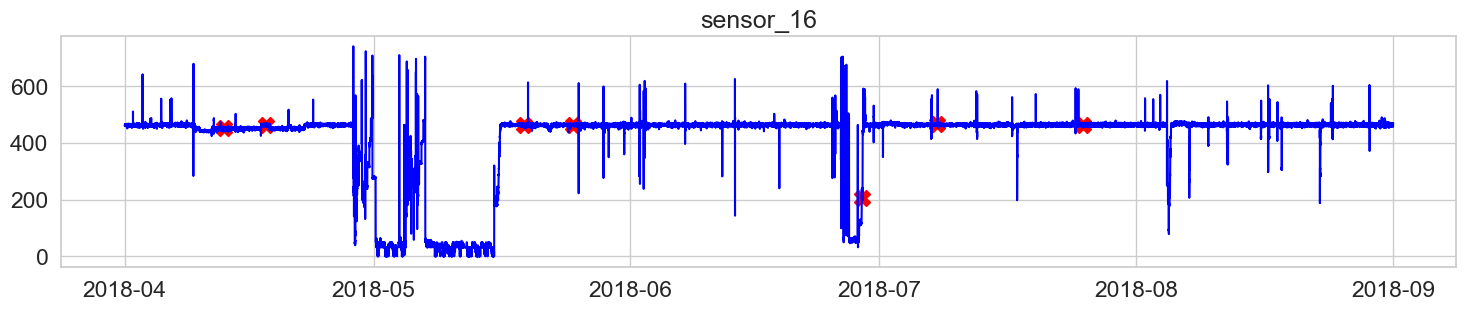

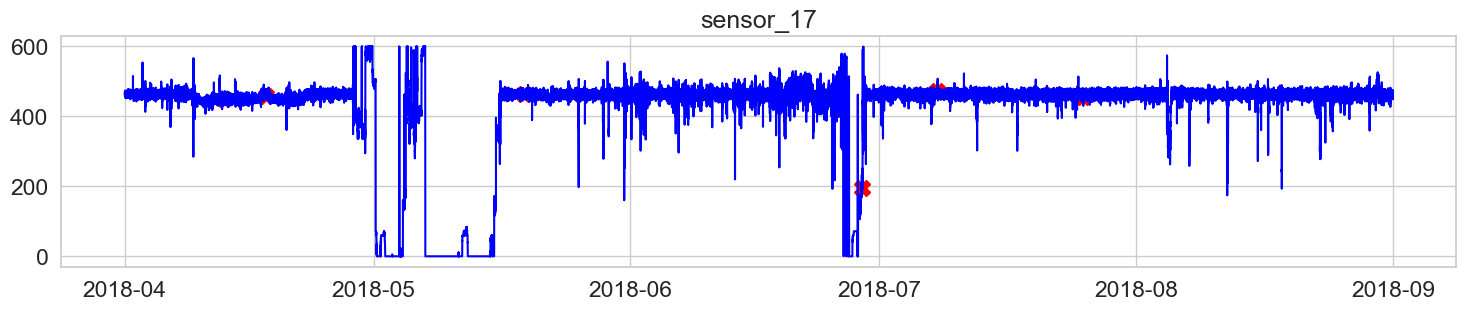

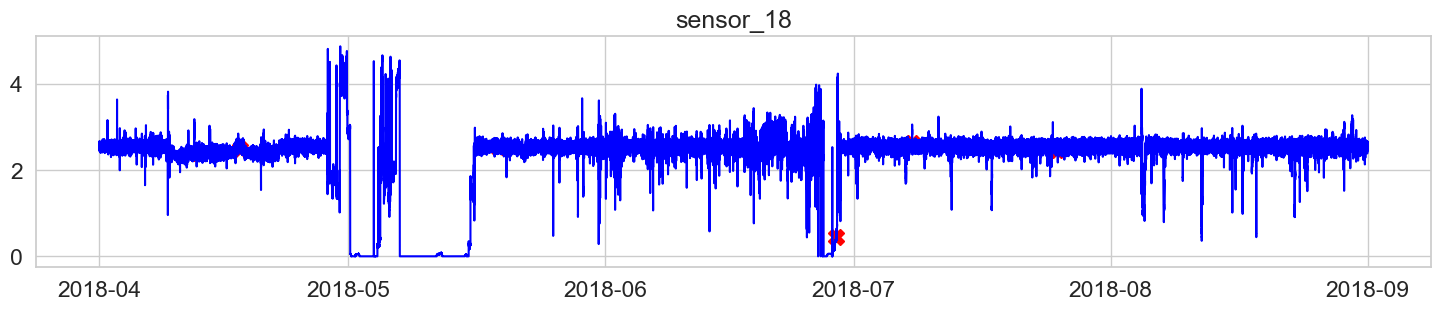

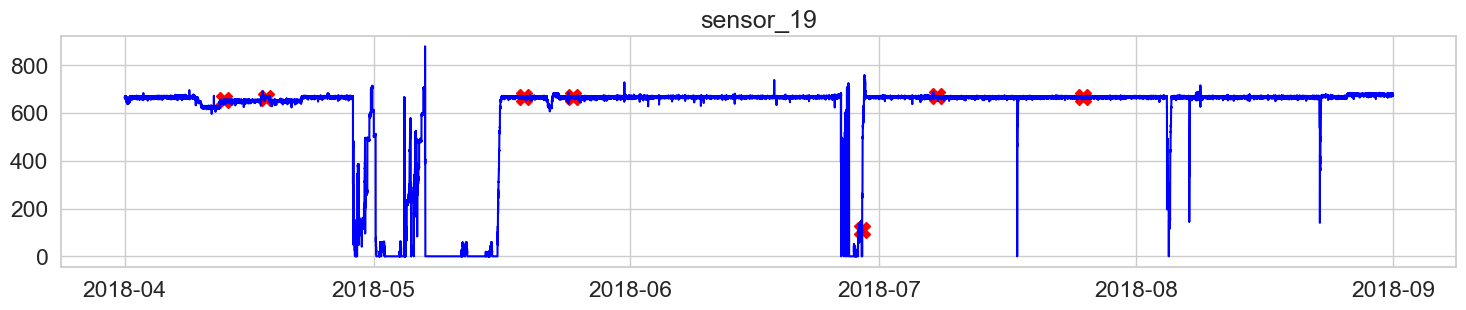

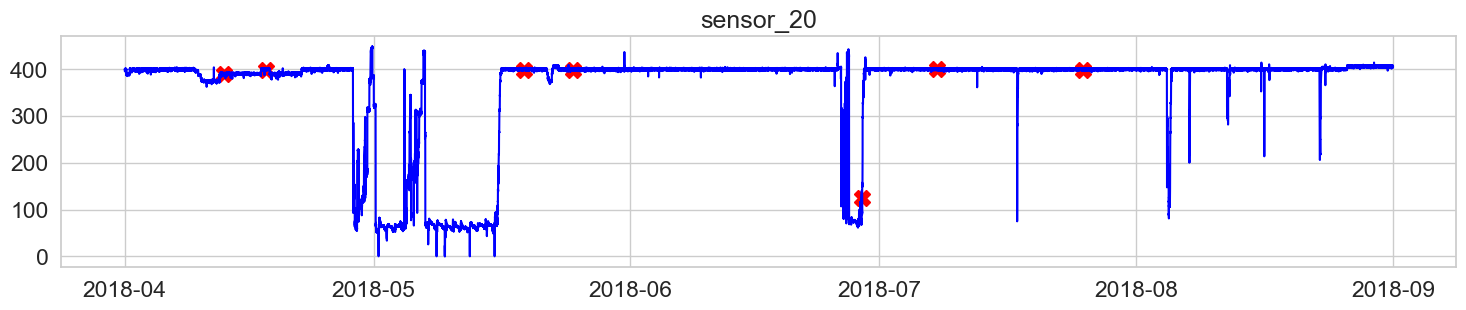

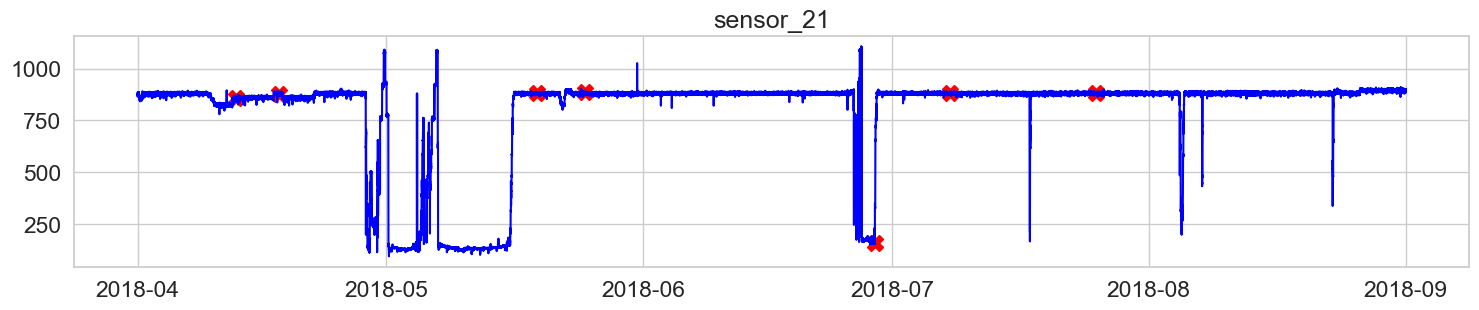

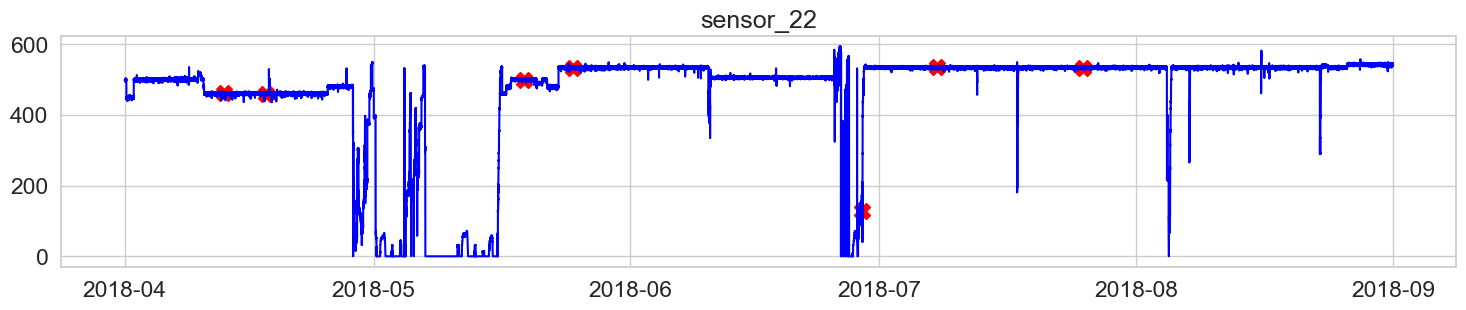

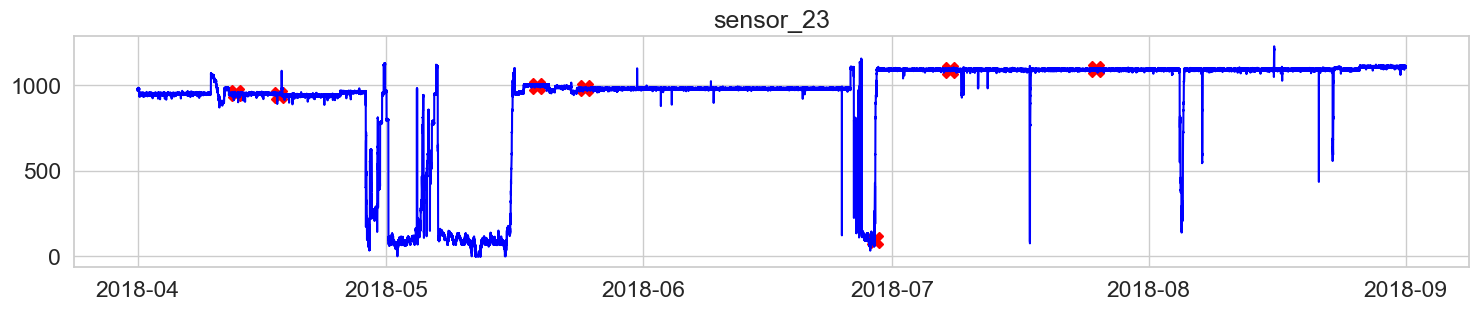

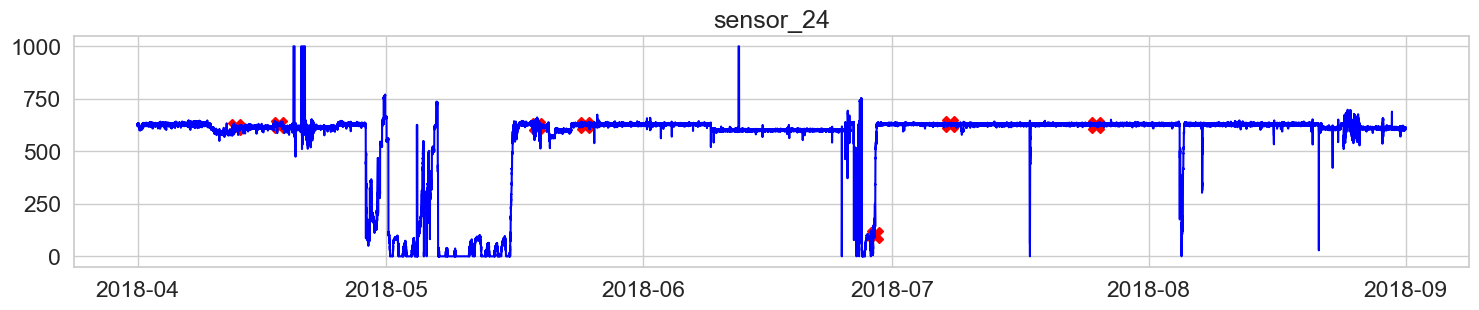

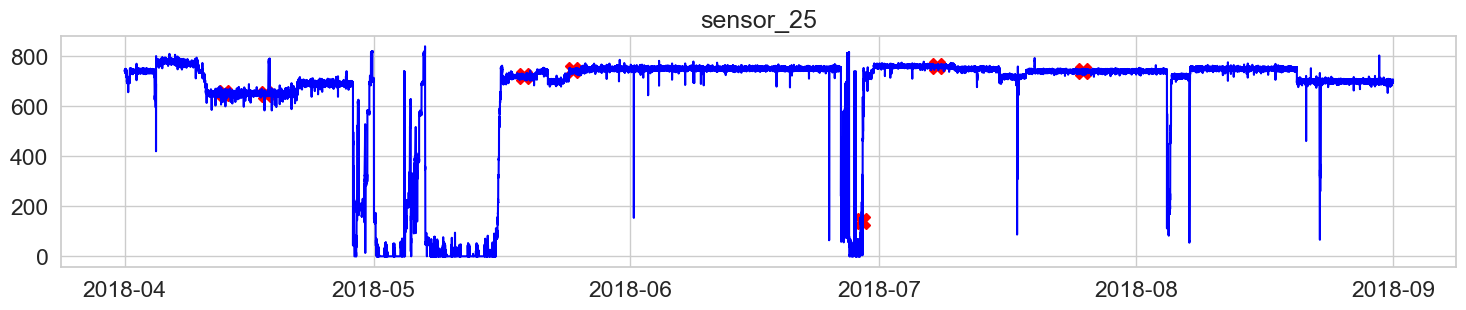

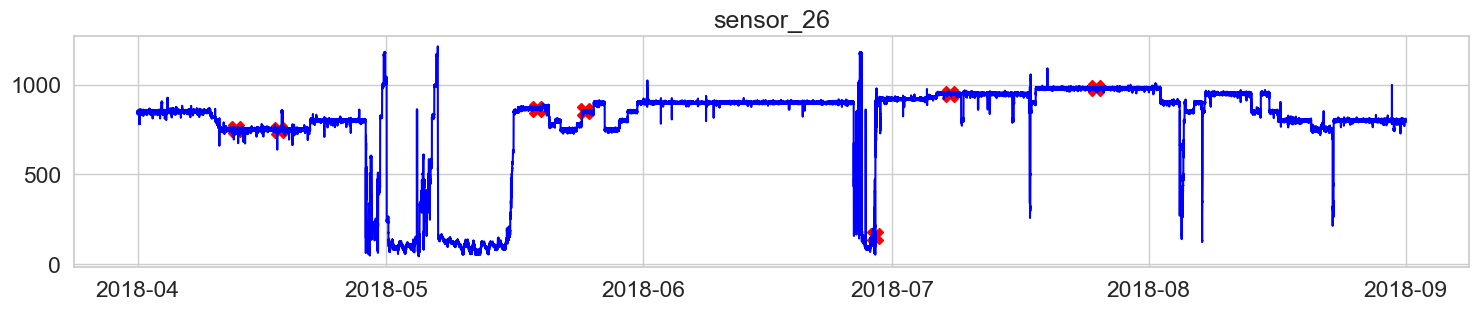

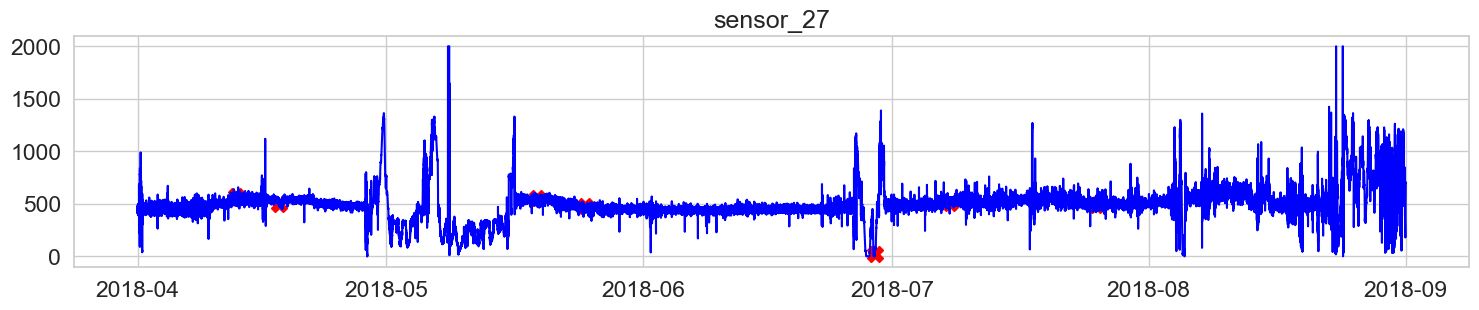

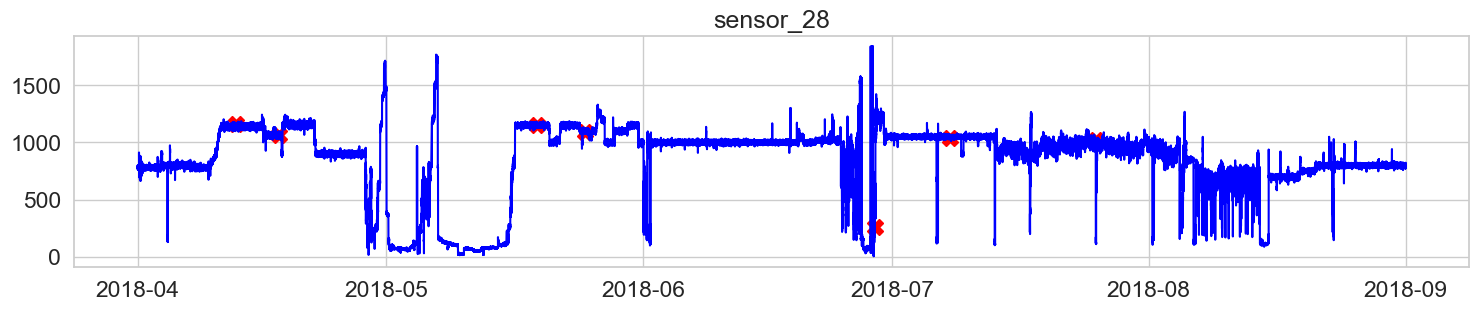

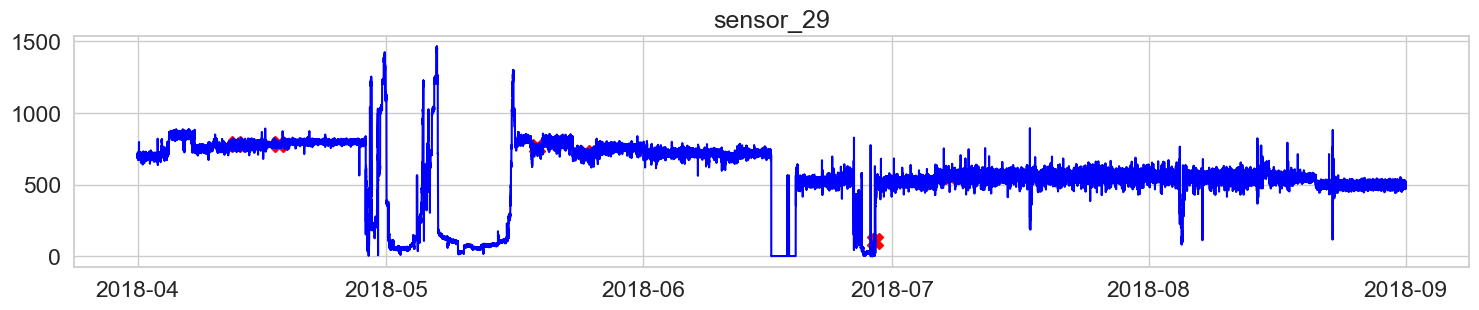

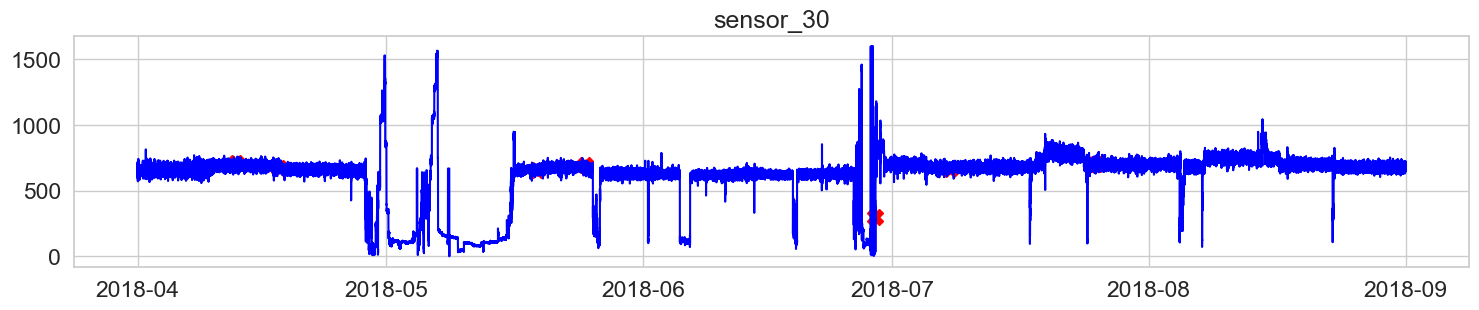

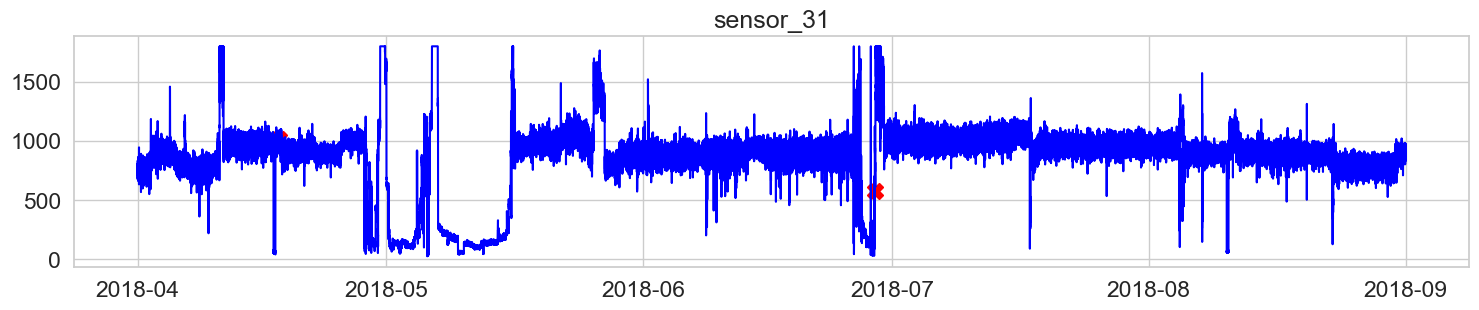

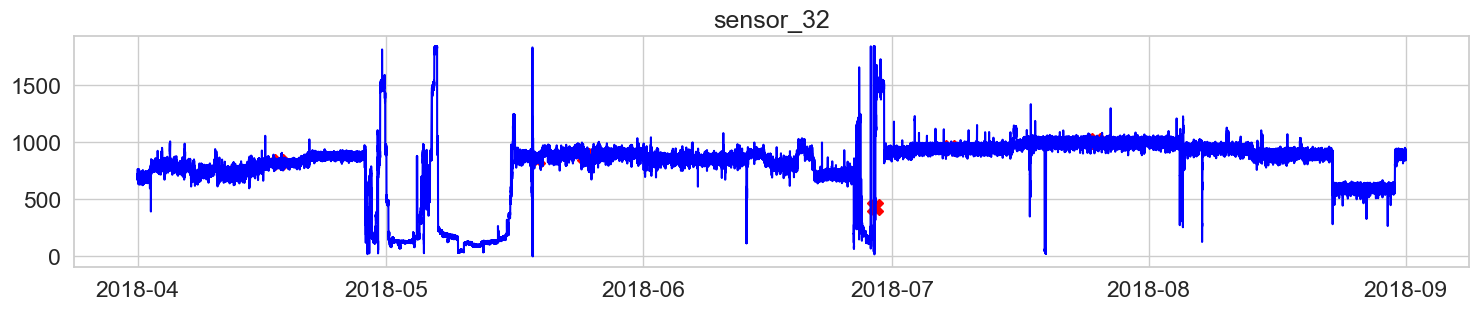

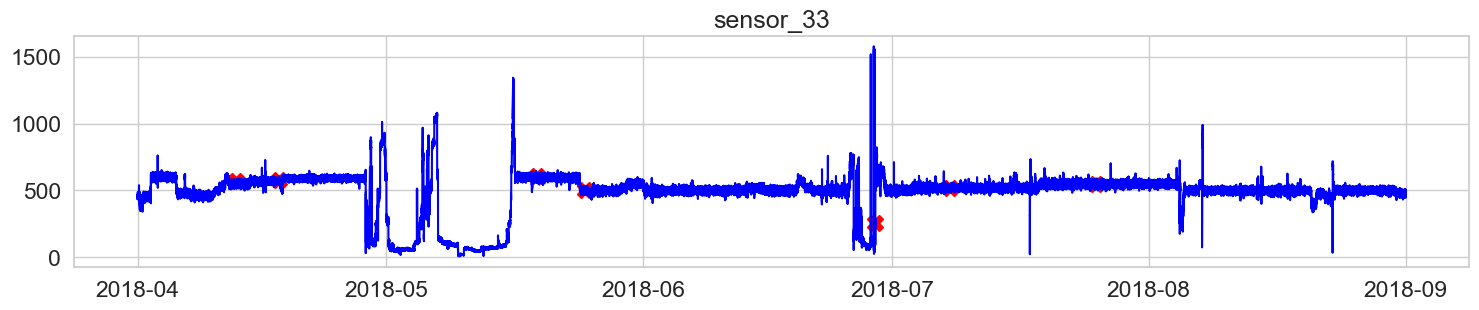

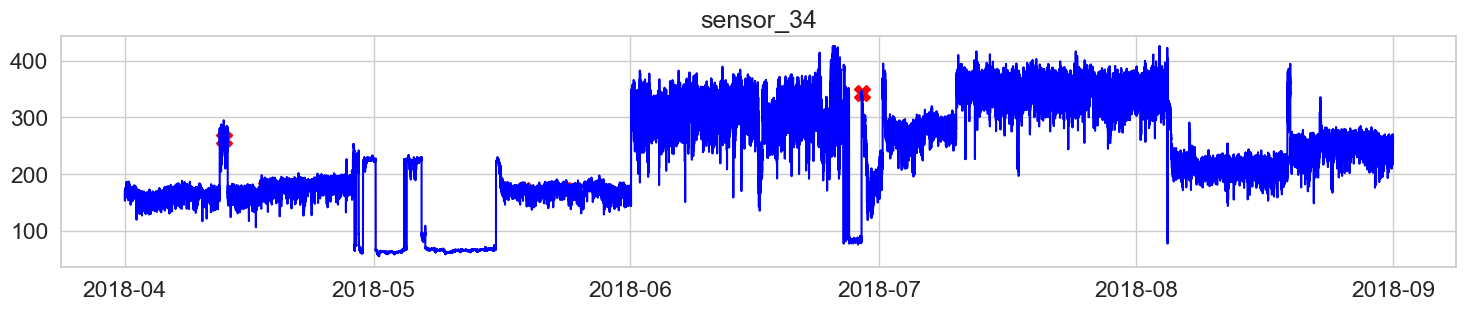

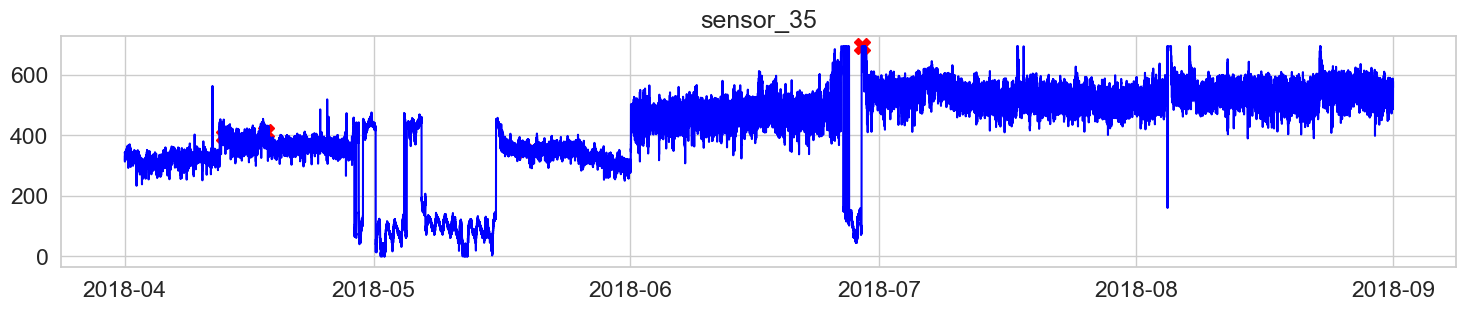

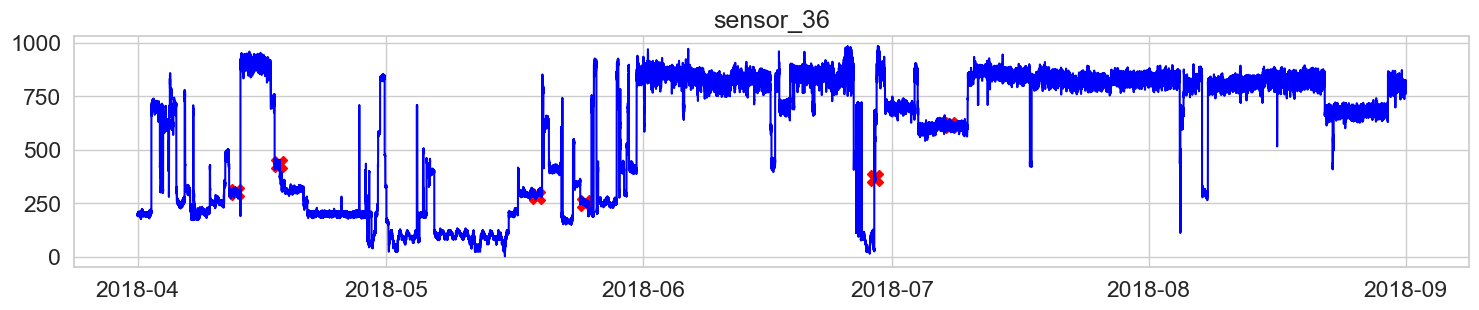

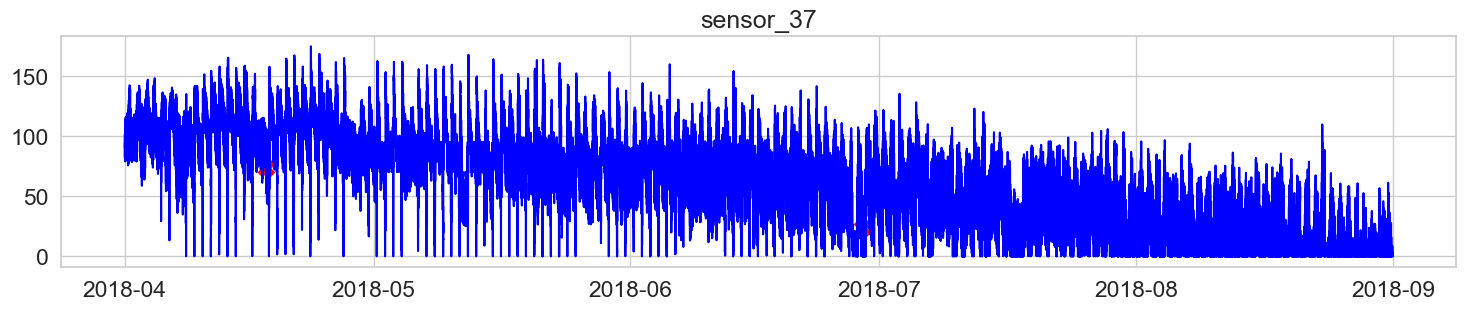

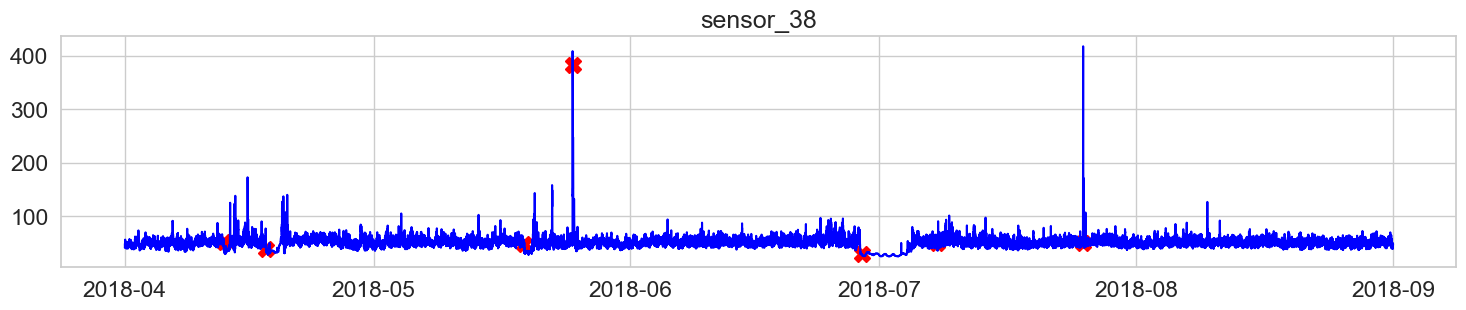

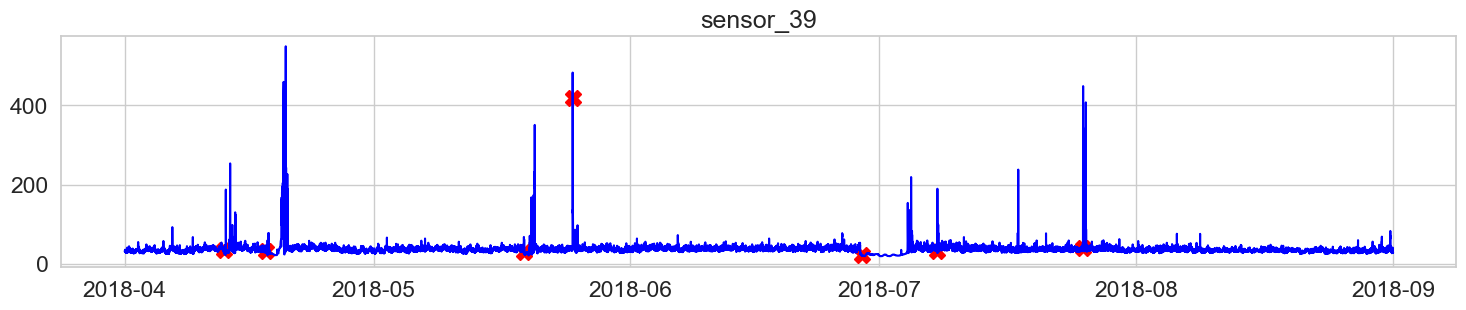

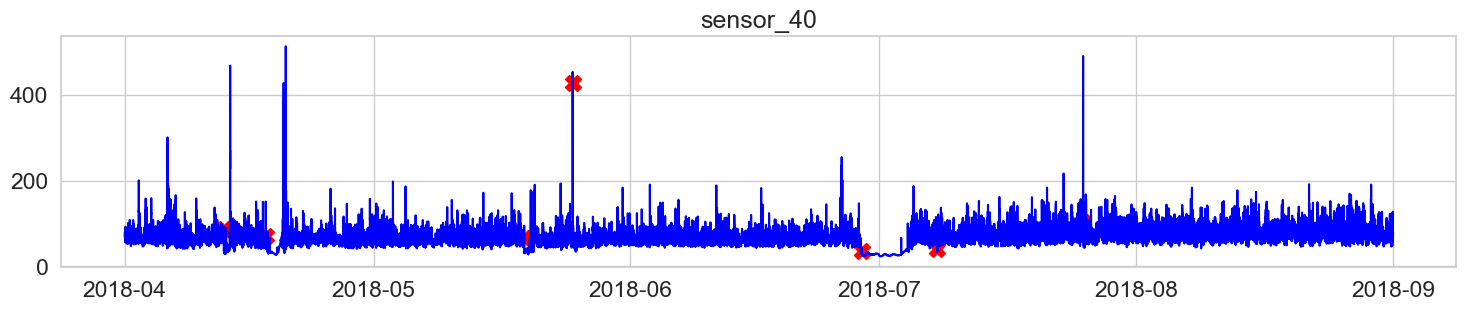

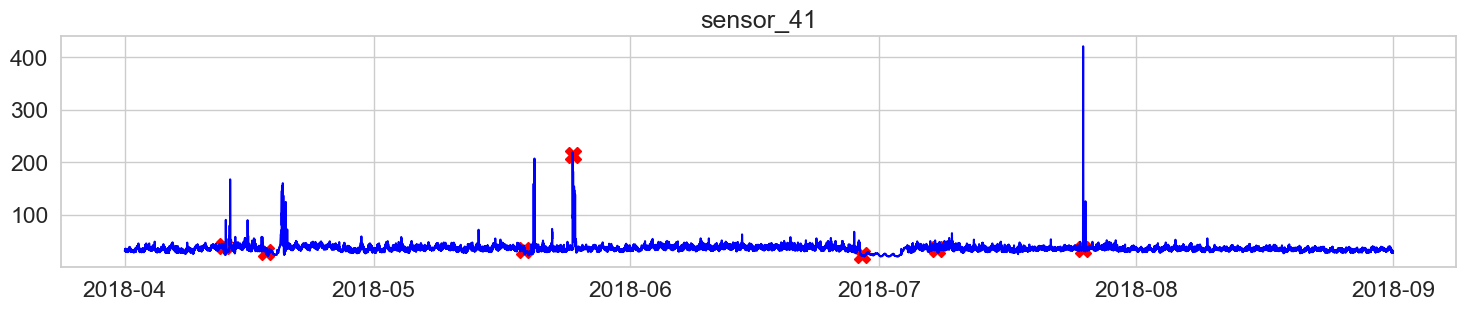

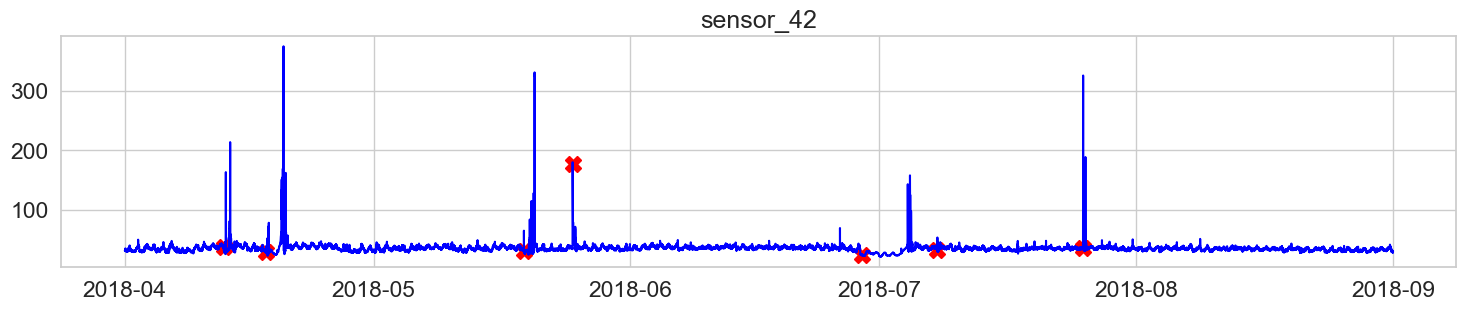

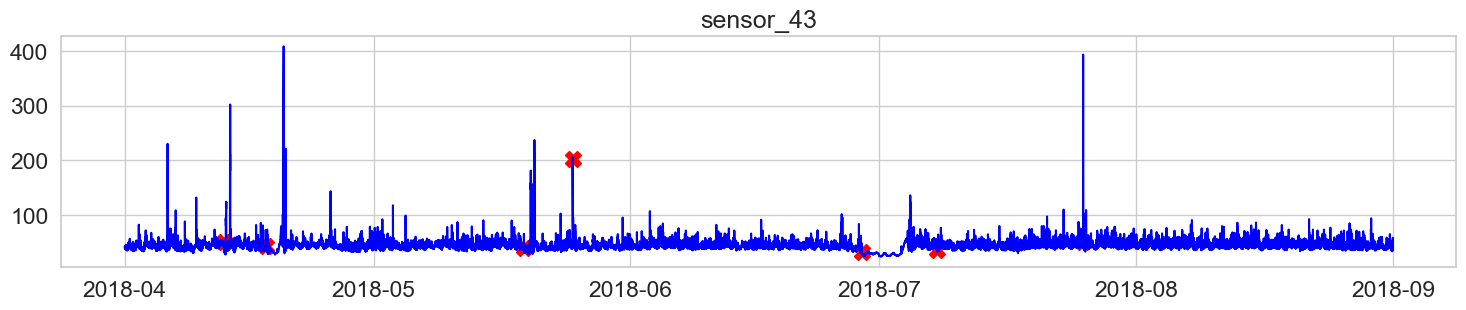

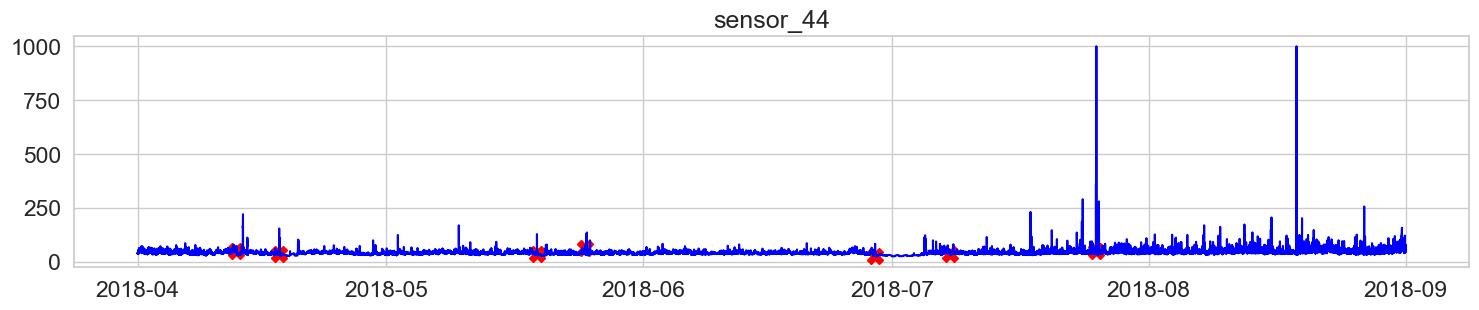

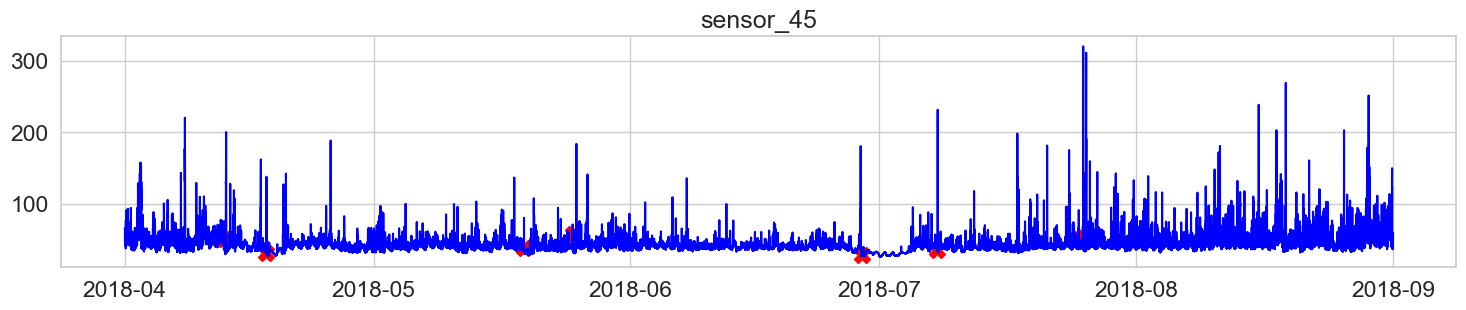

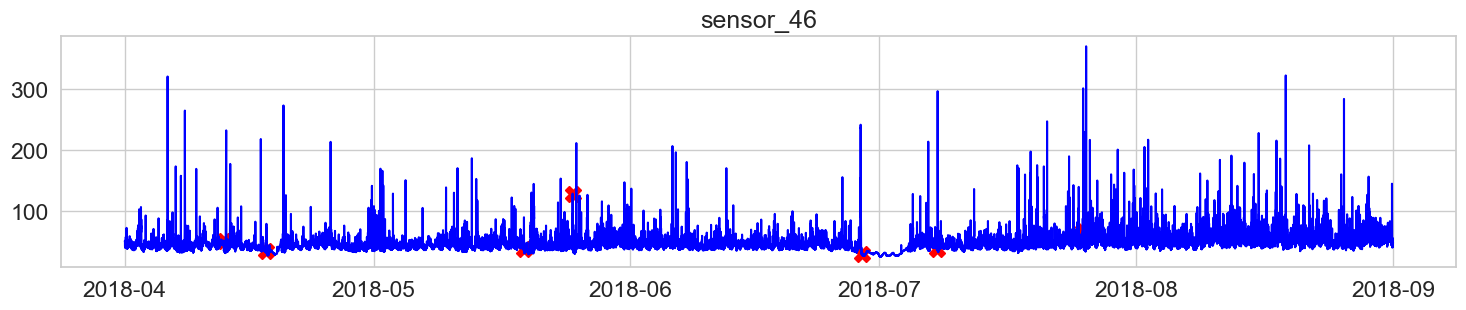

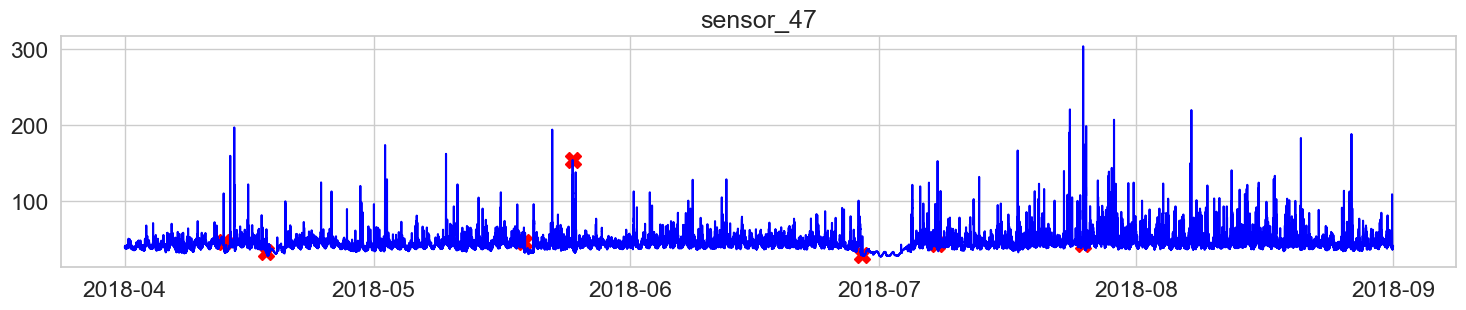

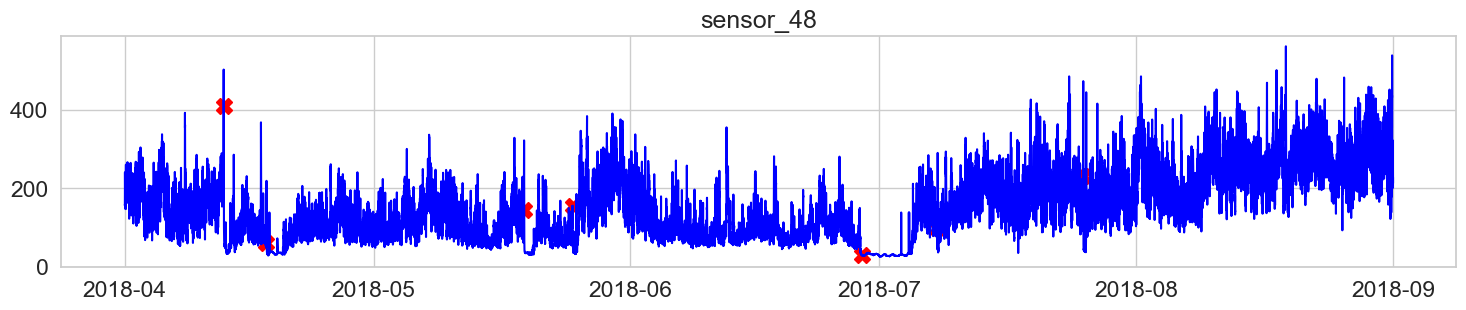

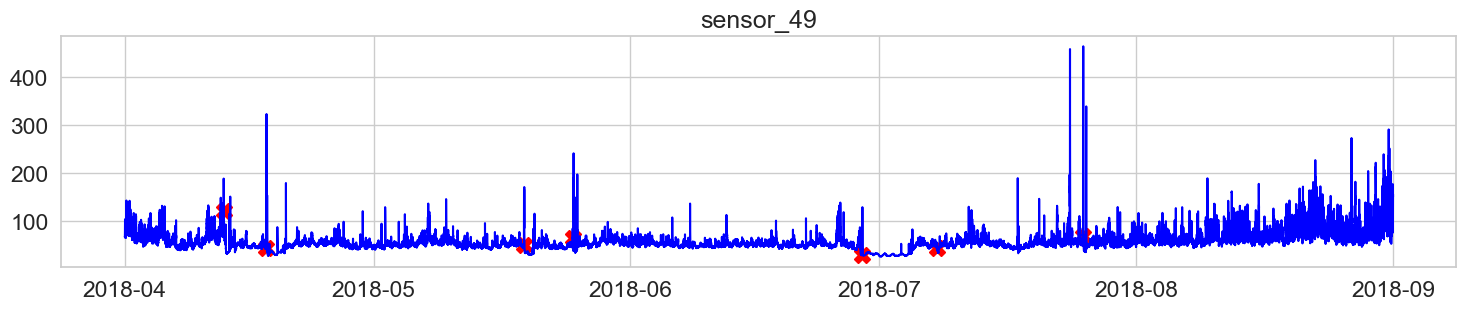

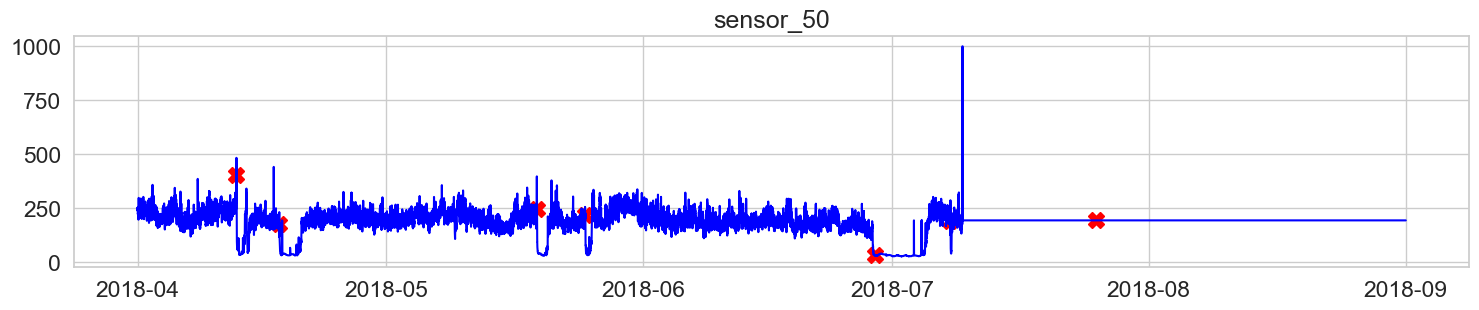

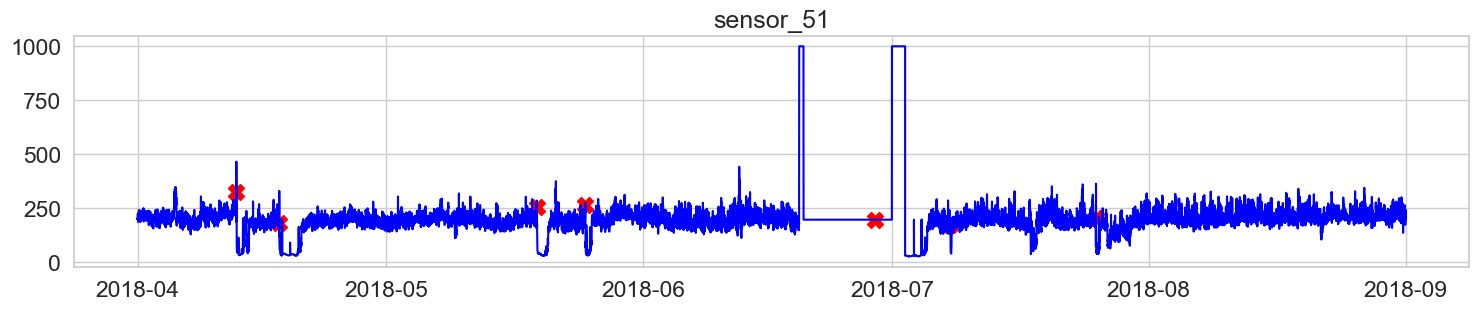

In [21]:
#Extract the readings from the broken state of the pump
broken = data[data['machine_status']=='BROKEN']

data_2=data.drop(['machine_status'], axis=1)
names=data_2.columns
for name in names:
    _=plt.figure(figsize=(18,3))
    _=plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _=plt.plot(data[name], color='blue')
    _=plt.title(name)
    plt.show()

### Pre-processing

In [22]:
from sklearn.preprocessing import StandardScaler
Feature_input=data.iloc[:, 0:51]
Feature_names=Feature_input.columns
scaler=StandardScaler()
scaled_features=scaler.fit_transform(Feature_input)
scaled_features=pd.DataFrame(scaled_features, columns=Feature_names)
scaled_features.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,0.221531,-0.151947,0.639367,1.057656,0.303417,0.177086,-0.043528,0.128859,0.178536,0.119982,...,-0.358966,-0.176788,-0.260496,1.759655,0.185913,-0.588619,0.086316,0.553164,1.063209,-0.008859
1,0.221531,-0.151947,0.639367,1.057656,0.303417,0.177086,-0.043528,0.128859,0.178536,0.119982,...,-0.358966,-0.176788,-0.260496,1.759655,0.185913,-0.588619,0.086316,0.553164,1.063209,-0.008859
2,0.170259,-0.072887,0.639367,1.093546,0.334759,0.008636,-0.084091,0.085614,0.203678,0.099020,...,-0.358966,-0.200369,-0.285493,1.737114,0.204413,-0.588619,0.061687,0.522933,1.030378,0.013040
3,0.209321,-0.151947,0.627530,1.093545,0.260019,0.207682,-0.087469,0.182094,0.243184,0.133959,...,-0.384350,-0.271111,-0.310489,1.692032,0.204413,-0.588619,0.061687,0.507817,1.013964,0.007566
4,0.172701,-0.138771,0.639367,1.093545,0.317882,0.184557,-0.070569,0.165459,0.243184,0.133959,...,-0.384350,-0.223949,-0.335486,1.714573,0.241413,-0.533197,0.089835,0.492701,1.046794,-0.008859


### Principal Component Analysis

PCA prohibits predictive algorithms from having problems with data overfitting by eliminating superfluous correlated variables.Moreover, it plays a significant role in data exploration and visualization, aiding in uncovering hidden patterns and insights.

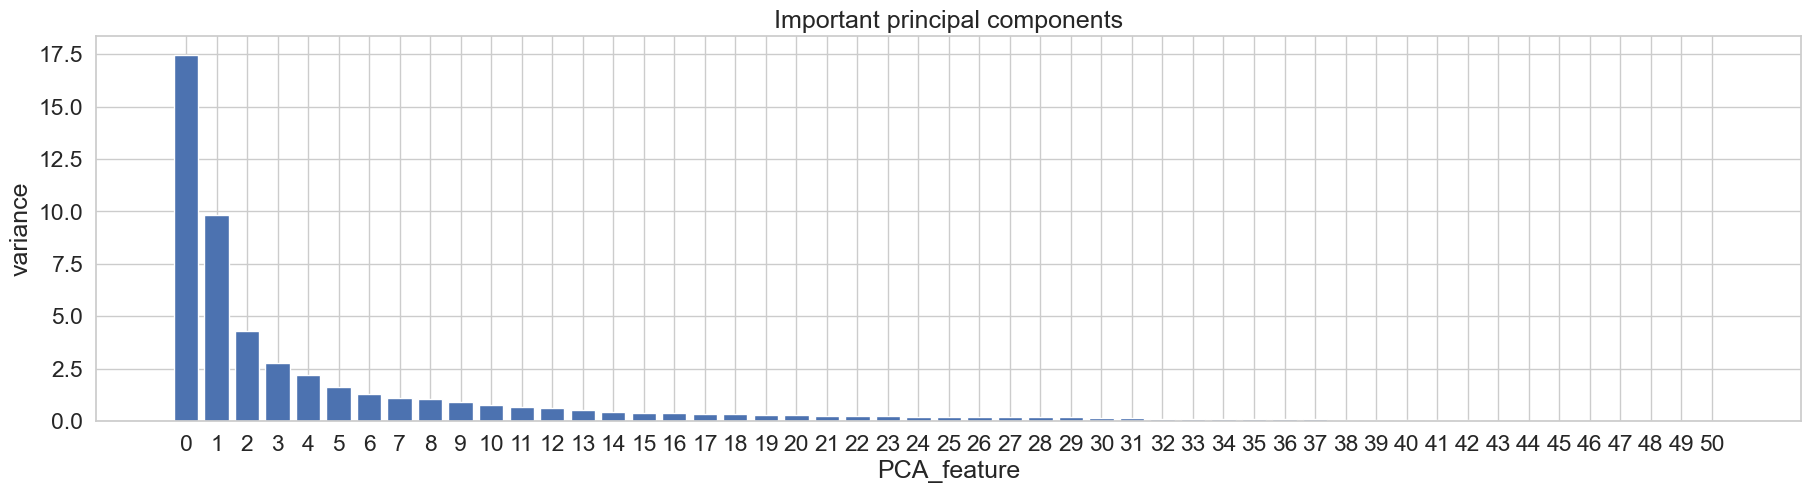

In [23]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(scaled_features)

features = range(pca.n_components_)
_=plt.figure(figsize=(22, 5))
_=plt.bar(features, pca.explained_variance_)
_=plt.xlabel('PCA_feature')
_=plt.ylabel('variance')
_=plt.xticks(features)
_=plt.title("Important principal components")
plt.show()

To mitigate computational expenses and enhance efficiency, a dimensionality reduction technique, Principal Component Analysis (PCA), is employed to extract new features from the 52 pump sensors for training the model.

As we can see, the majority of the variance in the dataset are explained with two principal components.

In [24]:
pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Printing the summary
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", pca.explained_variance_ratio_.cumsum())


Explained variance ratio: [3.42709200e-01 1.92686686e-01 8.47003850e-02 5.46605829e-02
 4.33986775e-02 3.19681199e-02 2.56222179e-02 2.21496746e-02
 2.10320038e-02 1.77888688e-02 1.53310726e-02 1.35754382e-02
 1.19557313e-02 1.02448259e-02 8.79340977e-03 8.09943854e-03
 7.35001223e-03 6.91088582e-03 6.65386210e-03 5.89216170e-03
 5.58221755e-03 5.11036818e-03 4.89551977e-03 4.64573736e-03
 4.40010426e-03 4.07346038e-03 3.92728664e-03 3.87493303e-03
 3.64801320e-03 3.57076915e-03 3.09350016e-03 2.93552915e-03
 2.50653489e-03 2.19911442e-03 2.07483424e-03 1.98936696e-03
 1.95776925e-03 1.71015668e-03 1.38581126e-03 1.01247963e-03
 8.96973275e-04 8.75330737e-04 7.81304795e-04 3.79522205e-04
 2.88780082e-04 1.88335640e-04 1.75922279e-04 1.27974854e-04
 1.11503178e-04 3.33771871e-05 2.42154094e-05]
Cumulative explained variance ratio: [0.3427092  0.53539589 0.62009627 0.67475685 0.71815553 0.75012365
 0.77574587 0.79789554 0.81892755 0.83671642 0.85204749 0.86562293
 0.87757866 0.88782348 0

In [25]:
pca=PCA(n_components=2)
pComponents=pca.fit_transform(scaled_features)
principal_components = pd.DataFrame(data =pComponents, columns = ['pc1', 'pc2'])
principal_components

,pc1,pc2
0,-0.024127,0.761067
1,-0.024127,0.761067
2,-0.164716,0.766021
3,-0.165260,0.798585
4,-0.120199,0.911922
...,...,...
220315,-2.018872,2.419792
220316,-2.018993,2.435447
220317,-2.032588,2.430486
220318,-1.918555,2.439248


#### Checking Stationary and autocorrelation

In [26]:
#Stationary analysis
from statsmodels.tsa.stattools import adfuller
result= adfuller(principal_components['pc1'])
print(result[1])

0.00013443084797485768


The p-value obtained, which is significantly lower than the chosen significance level, leads to the rejection of the null hypothesis, indicating that the time series is stationary.

In [27]:
#Autocorrelation

#change in daily mean
pca1=principal_components['pc1'].pct_change()
#compute autocorrelation
autocorrelation=pca1.dropna().autocorr()
print('Autocorrelation is:' , autocorrelation)

Autocorrelation is: -0.00010682803428231265


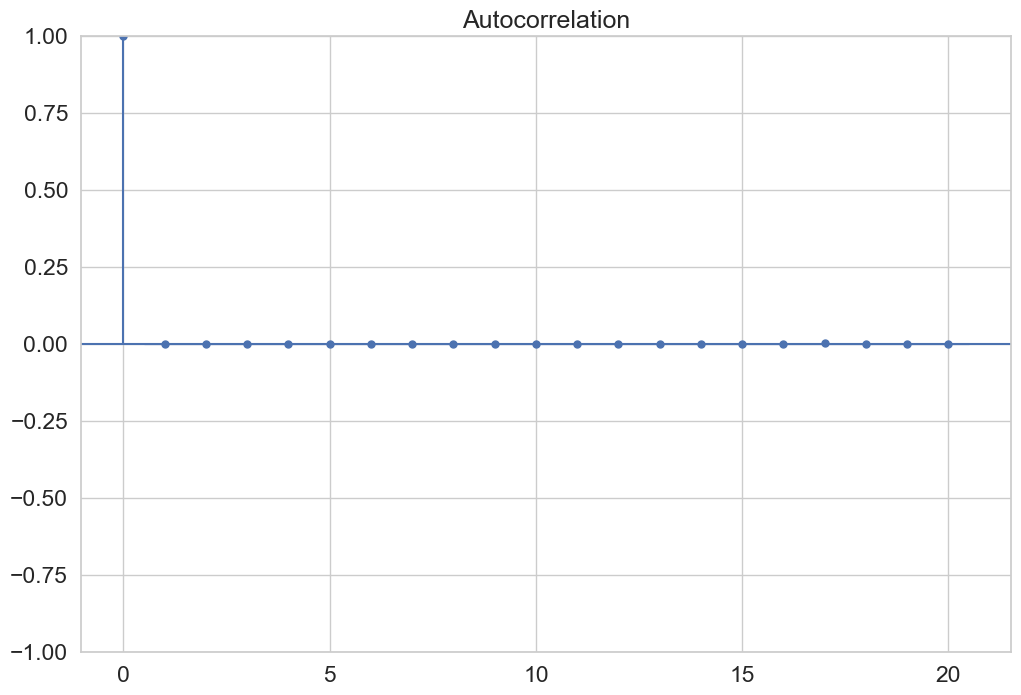

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pca1.dropna(), lags=20, alpha=0.05)
plt.show()

The autocorrelation coefficient of -0.0001068 indicates negligible autocorrelation among the data points, suggesting that there is no significant linear relationship between the observations in the time series.

Autocorrelation is: -2.6693500751612383e-06


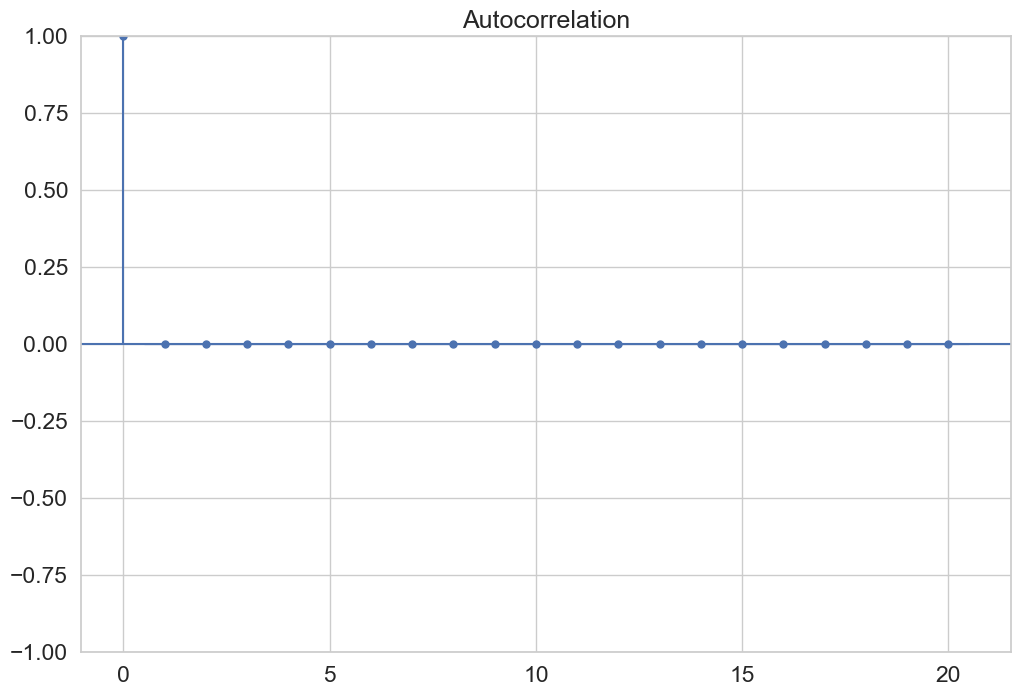

In [29]:
#change in daily mean
pca2=principal_components['pc2'].pct_change()
#compute autocorrelation
autocorrelation=pca2.dropna().autocorr()
print('Autocorrelation is:' , autocorrelation)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(pca2.dropna(), lags=20, alpha=0.05)
plt.show()

### Modeling

In [30]:
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=2, random_state=13)

kmeans.fit(principal_components.values)

labels=kmeans.predict(principal_components.values)

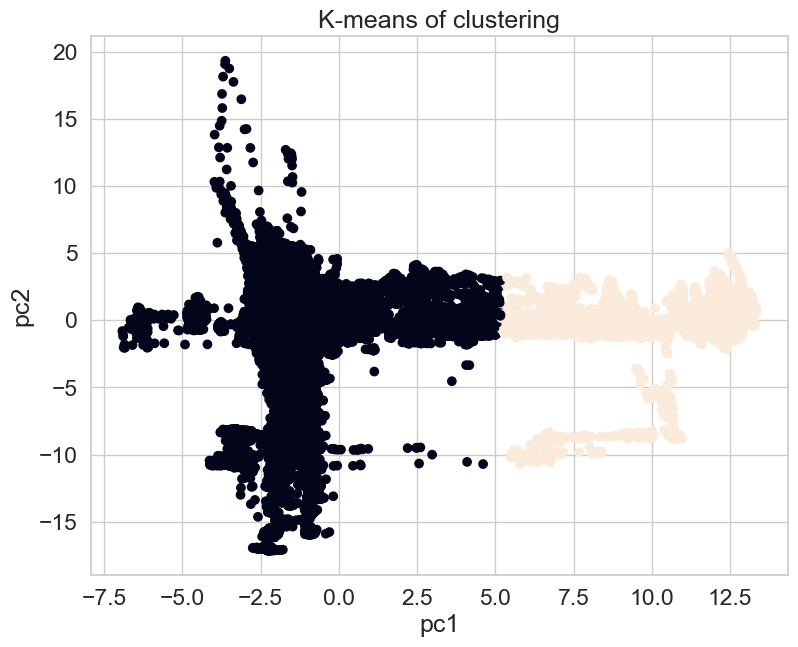

In [31]:

_=plt.figure(figsize=(9, 7))
_=plt.scatter(principal_components['pc1'],principal_components['pc2'],c=labels)
_=plt.xlabel('pc1')
_=plt.ylabel('pc2')
_=plt.title("K-means of clustering")
plt.show()

In [32]:
#write a function that calculates the distance between each point and
# the centroid of the closets cluster

def getDistanceByPoint(data, model):
    distance=[]
    for i in range(0,len(data)):
        Xa=np.array(data.loc[i])
        Xb=model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [33]:
#assuming that 13% of the dataset are anomalies
outliers_fraction=0.13

distance=getDistanceByPoint(principal_components, kmeans) # get the distance between each point and its nearest centroid
# the biggest distance is considered as anomaly

number_of_outliers=int(outliers_fraction*len(distance)) 

#Take the minimum of the largest 13% of the entire dataset

threshold=distance.nlargest(number_of_outliers).min()

#Anomally1 contains the anomaly result of the above method cluster (0:normal, 1:

principal_components['kmeans_anomaly']=(distance >= threshold).astype(int)




In [34]:
principal_components.head()

,pc1,pc2,kmeans_anomaly
0,-0.024127,0.761067,0
1,-0.024127,0.761067,0
2,-0.164716,0.766021,0
3,-0.165260,0.798585,0
4,-0.120199,0.911922,0


In [35]:
principal_components['kmeans_anomaly'].value_counts()

kmeans_anomaly
0    191679
1     28641
Name: count, dtype: int64

### Visualization over different sensors

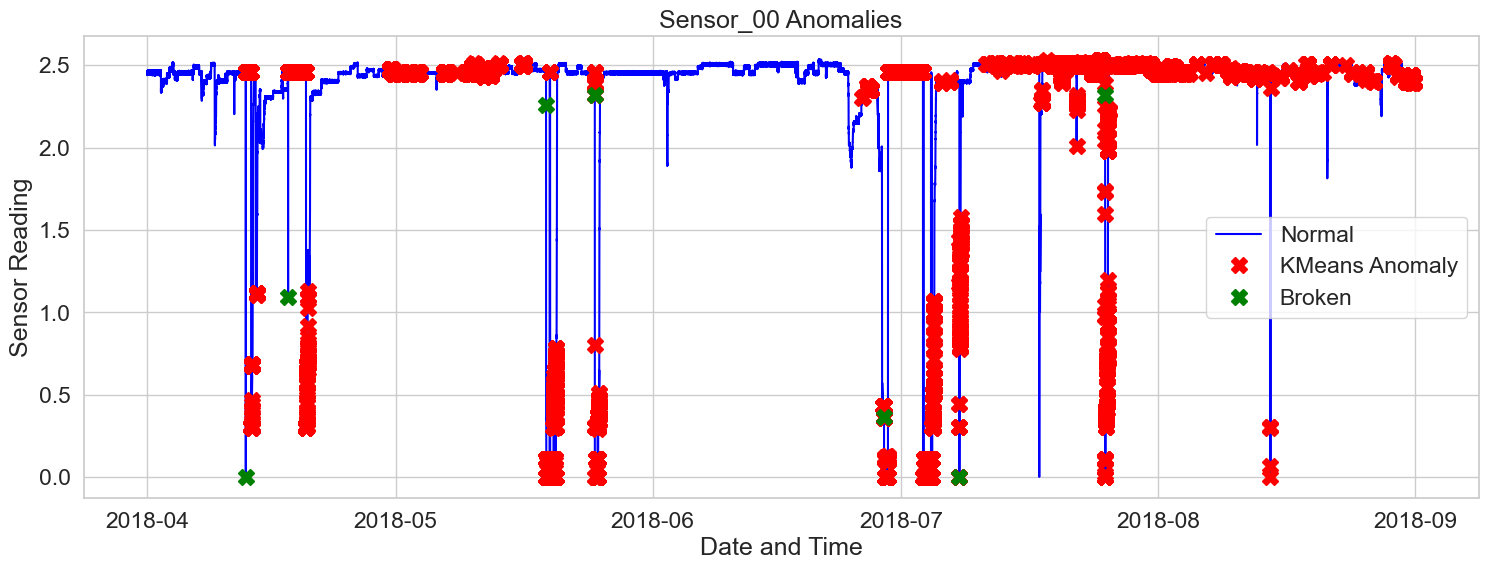

In [36]:
Broken_mac=data[data["machine_status"]=="BROKEN"]
data['kmeans_anomaly']=pd.Series(principal_components['kmeans_anomaly'].values, index=data.index)
a = data[data['kmeans_anomaly']==1]

_=plt.figure(figsize=(18, 6))
_=plt.plot(data['sensor_00'],color='blue',label='Normal')
_=plt.plot(a['sensor_00'], linestyle='none', marker='X', color='red', markersize=12, label='KMeans Anomaly')
_=plt.plot(Broken_mac['sensor_00'], linestyle='none', marker='X', color='green', markersize=12, label='Broken')
_=plt.xlabel('Date and Time')
_=plt.ylabel('Sensor Reading')
_=plt.title("Sensor_00 Anomalies")
_=plt.legend(loc='best')
plt.show()

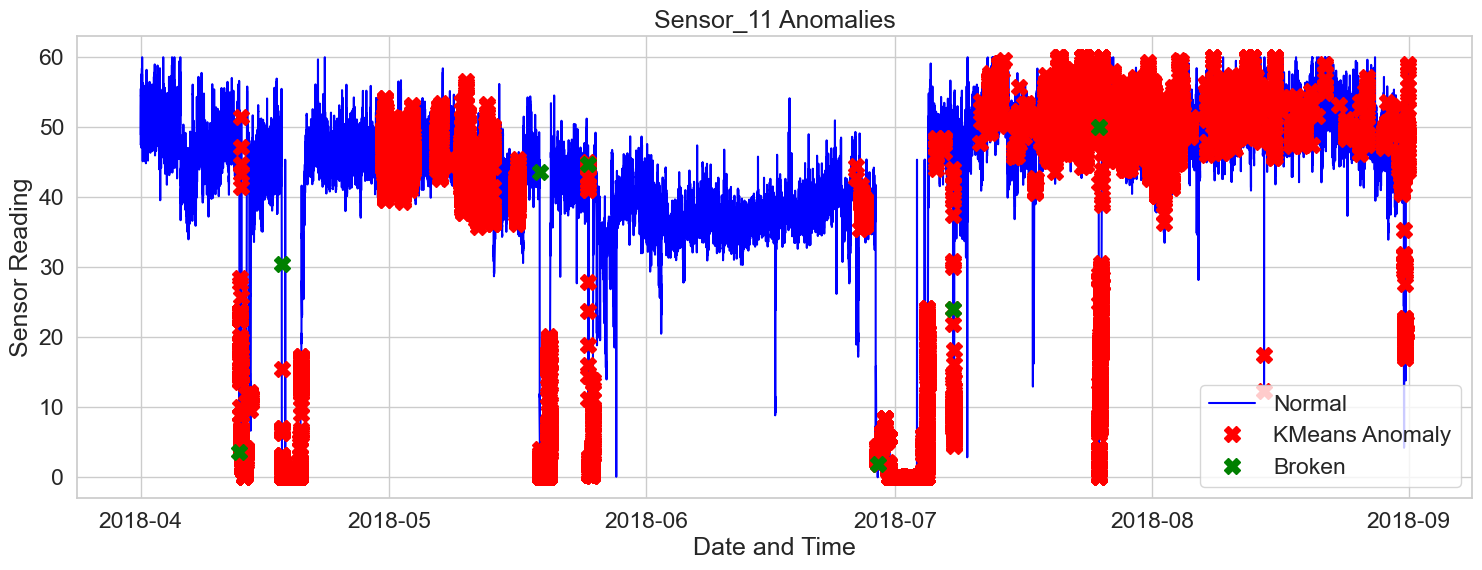

In [37]:
Broken_mac=data[data["machine_status"]=="BROKEN"]
data['kmeans_anomaly']=pd.Series(principal_components['kmeans_anomaly'].values, index=data.index)
a = data[data['kmeans_anomaly']==1]

_=plt.figure(figsize=(18, 6))
_=plt.plot(data['sensor_11'],color='blue',label='Normal')
_=plt.plot(a['sensor_11'], linestyle='none', marker='X', color='red', markersize=12, label='KMeans Anomaly')
_=plt.plot(Broken_mac['sensor_11'], linestyle='none', marker='X', color='green', markersize=12, label='Broken')
_=plt.xlabel('Date and Time')
_=plt.ylabel('Sensor Reading')
_=plt.title("Sensor_11 Anomalies")
_=plt.legend(loc='best')
plt.show()

### Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest
model_IF=IsolationForest(random_state=13)
model_IF.fit(principal_components.drop('kmeans_anomaly', axis=1))
principal_components['if_anomaly']=pd.Series(model_IF.predict(principal_components.drop('kmeans_anomaly', axis=1)))
principal_components.head()

,pc1,pc2,kmeans_anomaly,if_anomaly
0,-0.024127,0.761067,0,1
1,-0.024127,0.761067,0,1
2,-0.164716,0.766021,0,1
3,-0.165260,0.798585,0,1
4,-0.120199,0.911922,0,1


Isolation forest gives 1 if it is normal and -1 if it is anomly 

In [39]:
principal_components['if_anomaly'].value_counts()

if_anomaly
 1    172540
-1     47780
Name: count, dtype: int64

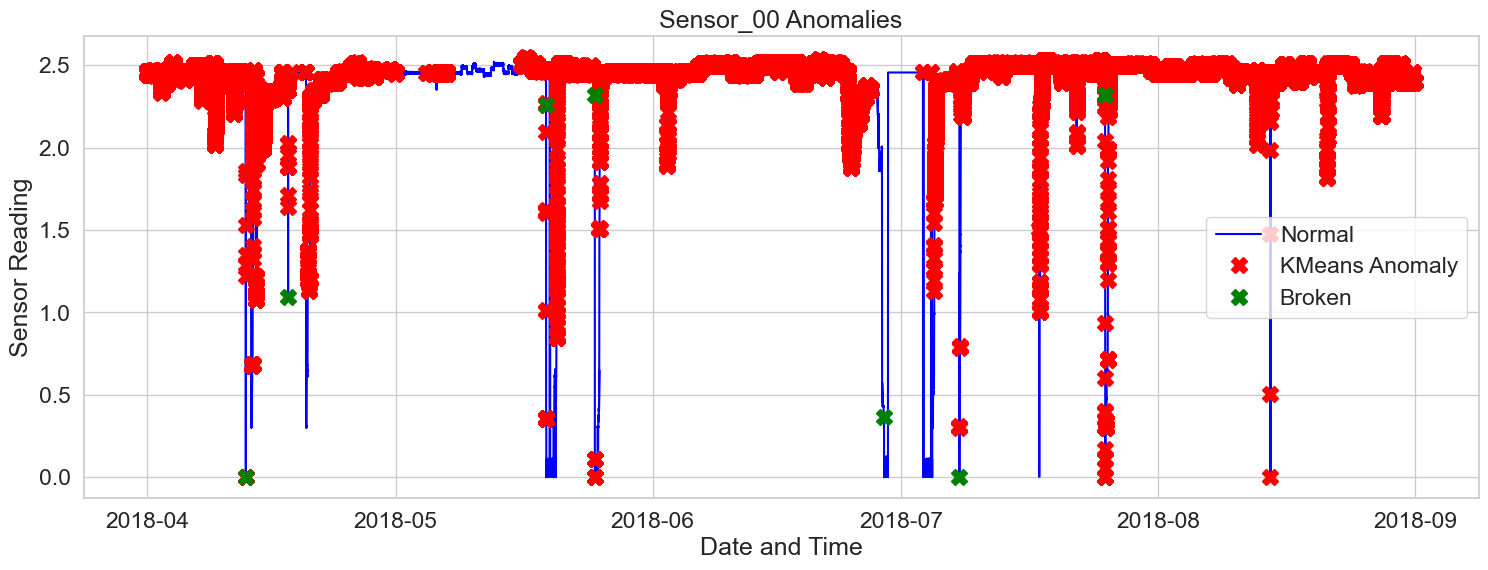

In [40]:
data['if_anomaly']=pd.Series(principal_components['if_anomaly'].values, index=data.index)
a = data[data['if_anomaly']==1]

_=plt.figure(figsize=(18, 6))
_=plt.plot(data['sensor_00'],color='blue',label='Normal')
_=plt.plot(a['sensor_00'], linestyle='none', marker='X', color='red', markersize=12, label='KMeans Anomaly')
_=plt.plot(Broken_mac['sensor_00'], linestyle='none', marker='X', color='green', markersize=12, label='Broken')
_=plt.xlabel('Date and Time')
_=plt.ylabel('Sensor Reading')
_=plt.title("Sensor_00 Anomalies")
_=plt.legend(loc='best')
plt.show()

### Model Evaluation

In [41]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
predictions = data[['machine_status', 'kmeans_anomaly', 'if_anomaly']]
predictions.head()

,machine_status,kmeans_anomaly,if_anomaly
index,,,
2018-04-01 00:00:00,NORMAL,0,1
2018-04-01 00:01:00,NORMAL,0,1
2018-04-01 00:02:00,NORMAL,0,1
2018-04-01 00:03:00,NORMAL,0,1
2018-04-01 00:04:00,NORMAL,0,1


In [42]:
predictions.loc[predictions["if_anomaly"]==1, "if_anomaly"]=0
predictions.loc[predictions["if_anomaly"]==-1, "if_anomaly"]=1
predictions["machine_status"]=predictions["machine_status"].map(
{"NORMAL":0, "RECOVERING":1, "BROKEN":1})

#### K-means evaluation

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    205836
           1       0.48      0.94      0.63     14484

    accuracy                           0.93    220320
   macro avg       0.74      0.93      0.80    220320
weighted avg       0.96      0.93      0.94    220320



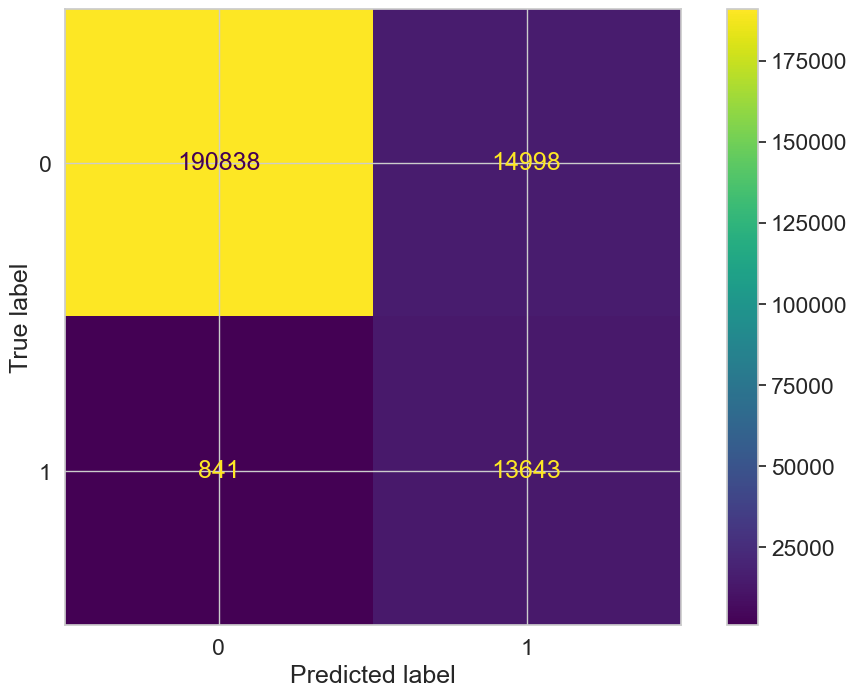

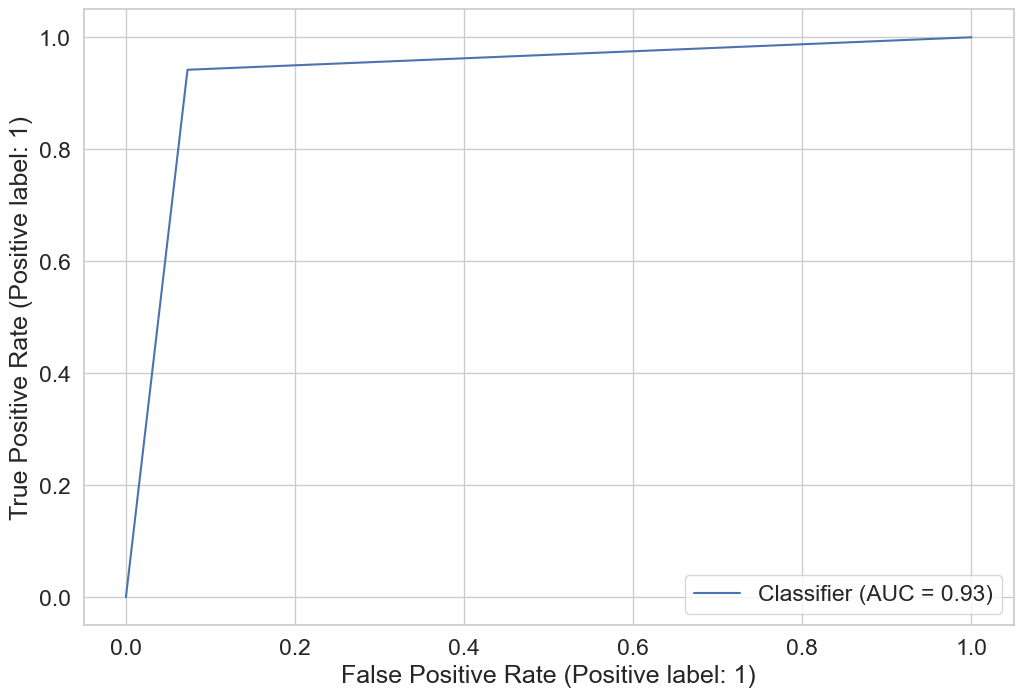

In [43]:
print(classification_report(predictions['machine_status'].values, 
                           predictions['kmeans_anomaly'].values))

ConfusionMatrixDisplay.from_predictions(predictions['machine_status'].values,
                                       predictions['kmeans_anomaly'].values)
plt.show()

RocCurveDisplay.from_predictions(predictions['machine_status'],
                                predictions['kmeans_anomaly'])
plt.show()


There were 14,998 instances where the model incorrectly predicted a positive status when it was not. This suggests some instances of false alarms or misclassifications of normal instances as positive.
The model only missed 841 instances where the pump status was actually positive. This suggests that the model has a relatively low rate of failing to identify actual positive cases. In general, the model performs well in terms of identifying actual positive cases (TP) and has a low rate of false negatives. However, there is high number of false negatives that would cause significant loss in the system. 

#### Isolation Forest Evaluation

              precision    recall  f1-score   support

           0       1.00      0.84      0.91    205836
           1       0.30      0.98      0.46     14484

    accuracy                           0.85    220320
   macro avg       0.65      0.91      0.68    220320
weighted avg       0.95      0.85      0.88    220320



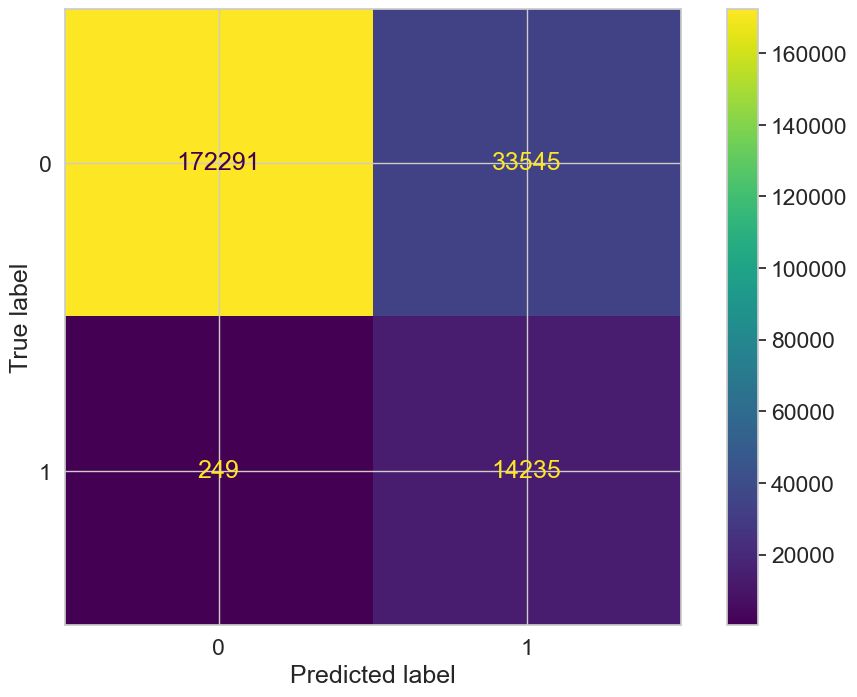

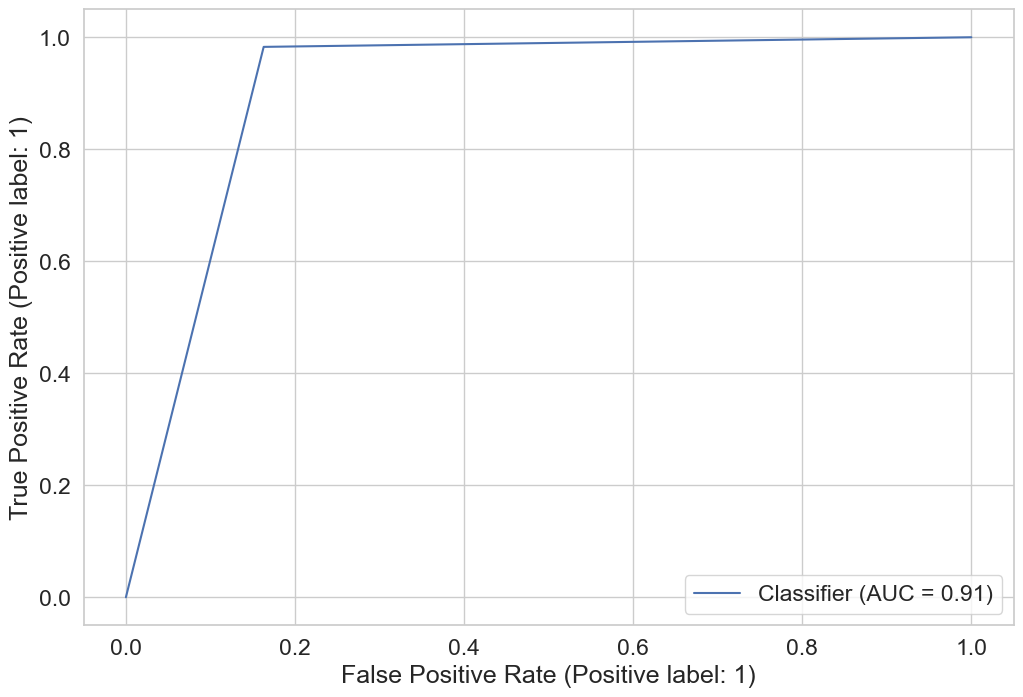

In [44]:
print(classification_report(predictions['machine_status'], 
                           predictions['if_anomaly']))

ConfusionMatrixDisplay.from_predictions(predictions['machine_status'],
                                       predictions['if_anomaly'])
plt.show()

RocCurveDisplay.from_predictions(predictions['machine_status'],
                                predictions['if_anomaly'])
plt.show()

The Isolation Forest model has substantially decreased the number of false negatives. This indicates that the Isolation Forest is better at identifying instances where the pump status is actually positive. However, Isolation Forest is more prone to incorrectly classifying normal instances as positive.

The choice between these models depends on the specific goals and priorities of your application. If reducing false negatives is crucial, the Isolation Forest may be preferred, but if minimizing false positives is more important, you might lean towards KMeans.